# Benchmarking

This notebook benchmarks 5 algorithms on a ASC dataset for constrained neural networks training and is divided as follows: 

##### Deterministic Constraints:
1. Unconstrained Optimization Adam
2. [SSL-ALM](https://arxiv.org/abs/2504.07607) (Adam + SGD)
3. [Switching Subgradient](https://arxiv.org/abs/2301.13314) 
4. [Cooper](https://github.com/cooper-org/cooper?tab=readme-ov-file) (ALM version)
5. [CHOP](https://github.com/openopt/chop)

##### Stochastic Constraints:
1. Unconstrained Optimization Adam
2. [SSL-ALM](https://arxiv.org/abs/2504.07607) (Adam + SGD)
3. [Switching Subgradient](https://arxiv.org/abs/2301.13314) 
4. [Cooper](https://github.com/cooper-org/cooper?tab=readme-ov-file) (ALM version)

##### Importance Sampling:
1. Train a model using the SSL-ALM with balanced sampling over groups (each subgroups has equal number of samples in each batch),
2. Train a model using the SSL-ALM without a balanced sampling over groups.


<br>

-------------------------------------------------------------------------------



# Deterministic constraints: Weight Regularization
 
We aim to minimize the expected loss of $f$, where the implicit regression model is a neural network with its weights in a unit sphere. We problem can be defined as

\begin{aligned}
\min_{x \in \mathbb{R}^n} \quad & \mathbb{E}[f(x,\xi)] \\
\text{s.t.} \quad & \|W_i\|_F \le 1, \quad \forall i \in \{1,\ldots,L\},
\end{aligned}

where the $W_i$ is a weight matrix of the fully connected neural network, $||\cdot||_F$ is a Frobenius norm.



In [ ]:
# define the torch seed here
seed_n = 1
n_epochs = 20

# log path file
log_path = "./data/logs/log_benchmark.npz"

#### 1. Unconstrained Optimization

For setting a reference bar

In [ ]:
# load and prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(
    features=ACSIncome.features, definition_df=definition_df
)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(
    acs_data, categories=categories, dummies=True
)

In [ ]:
sens_cols = ["SEX_Female", "SEX_Male"]
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")

print(sens_cols)
print(features.shape)
print(groups.shape)
print(labels.shape)

['SEX_Female', 'SEX_Male']
(46144, 800)
(46144, 2)
(46144, 1)


In [ ]:
# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.2, random_state=42
)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train, dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

features_test = torch.tensor(X_test, dtype=torch.float32)
labels_test = torch.tensor(y_test, dtype=torch.float32)
sens_test = torch.tensor(groups_test)
dataset_test = torch.utils.data.TensorDataset(features_test, labels_test)

In [ ]:
### SETUP FOR BENCHMARK TASK - common elements for all optimizers
from humancompatible.train.benchmark.algorithms.optim_wrapper import OptimLoopWrapper
from torch.nn import Sequential
import torch
latent_size1 = 64
latent_size2 = 32
def create_model():
    model = Sequential(
        torch.nn.Linear(features_train.shape[1], latent_size1),
        torch.nn.ReLU(),
        torch.nn.Linear(latent_size1, latent_size2),
        torch.nn.ReLU(),
        torch.nn.Linear(latent_size2, 1),
    )    
    return model

m = 6 # number of params in model
torch.manual_seed(seed_n)
criterion = torch.nn.BCEWithLogitsLoss()
bounds = [1.0]*m
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# function to calculate the constraints
def param_norms(model):
    norms = []
    for param in model.parameters():
        norm = torch.linalg.norm(param, ord=2)
        norms.append(norm)
    return norms

# forward function: expects to have (model, batch) as arguments
def fwd_unconstrained(model, batch):
    batch_inputs, batch_labels = batch
    out = model(batch_inputs)
    loss = criterion(out, batch_labels)
    return loss

def fwd_constrained_max(model, batch):
    batch_inputs, batch_labels = batch
    out = model(batch_inputs)
    loss = criterion(out, batch_labels)
    norms = param_norms(model)
    norms_bounded_eq = [torch.max(norm - bounds[i], torch.zeros_like(norm)) for i, norm in enumerate(norms)]
    return loss, norms_bounded_eq

def fwd_constrained_slack(model, batch, slack_vars):
    batch_inputs, batch_labels = batch
    out = model(batch_inputs)
    loss = criterion(out, batch_labels)
    norms = param_norms(model)
    norms_bounded_eq = [norm + slack_vars[i] - bounds[i] for i, norm in enumerate(norms)]
    return loss, norms_bounded_eq

def fwd_constrained(model, batch, slack_vars = None):
    if slack_vars is not None:
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()
    batch_inputs, batch_labels = batch
    out = model(batch_inputs)
    loss = criterion(out, batch_labels)
    norms = param_norms(model)
    if slack_vars is not None:
        norms_bounded_eq = [norm + slack_vars[i] - bounds[i] for i, norm in enumerate(norms)]
    else:
        norms_bounded_eq = [torch.max(norm - bounds[i], torch.zeros_like(norm)) for i, norm in enumerate(norms)]
    return loss, norms_bounded_eq

# 
# def train_iter_cooper(model, batch):    

@torch.inference_mode
def eval(model, batch):
    inputs, labels = batch
    output = model(inputs)
    constraints = param_norms(model)
    constraints = [c.numpy().item() for c in constraints]
    loss = criterion(output, labels)
    return loss.detach().numpy().item(), constraints

In [ ]:
# Adam
model = create_model()
# first backward pass sometimes takes ages
model(features_train[0]).backward()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

adam = OptimLoopWrapper(
    model = model,
    fwd = fwd_unconstrained,
    eval = eval,
    train_data = dataloader,
    eval_data = {'train': (features_train, labels_train)},
    optimizer = optimizer,
    use_vanilla_torch=True,
    verbose=True
)

adam.training_loop(epochs=n_epochs, max_iter=np.inf, max_runtime=np.inf, eval_every='epoch', save_every=-1)

epoch     0 iteration     0 total_iters     0 time     0 train_loss 0.6882 c_0_train 0.7378008365631104 c_1_train 0.1681336760520935 c_2_train 0.9287227988243103 c_3_train 0.39018142223358154 c_4_train 0.5339652895927429 c_5_train 0.11916934698820114
epoch     1 iteration     0 total_iters  2308 time 1.4245 train_loss 0.3852 c_0_train 7.194159507751465 c_1_train 0.4124360978603363 c_2_train 1.5141581296920776 c_3_train 0.4677649140357971 c_4_train 0.5245175957679749 c_5_train 0.15342265367507935
epoch     2 iteration     0 total_iters  4616 time 2.7759 train_loss 0.3690 c_0_train 9.270196914672852 c_1_train 0.5593320727348328 c_2_train 1.8806036710739136 c_3_train 0.5051527619361877 c_4_train 0.4639599025249481 c_5_train 0.1524360030889511
epoch     3 iteration     0 total_iters  6924 time 4.1223 train_loss 0.3570 c_0_train 10.61091423034668 c_1_train 0.7029558420181274 c_2_train 2.1593101024627686 c_3_train 0.5515404343605042 c_4_train 0.43976500630378723 c_5_train 0.1437537521123886


In [ ]:
import pandas as pd

adam_histories = []

# 4 runs of Adam:
for run in range(4):
    model = create_model()
    # first backward pass sometimes takes ages
    model(features_train[0]).backward()

    optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)
    adam = OptimLoopWrapper(
        model = model,
        fwd = fwd_unconstrained,
        eval = eval,
        train_data = dataloader,
        eval_data = {'train': (features_train, labels_train)},
        optimizer = optimizer,
        use_vanilla_torch=True,
        verbose=False
    )

    adam.training_loop(epochs=5, max_iter=np.inf, max_runtime=np.inf, eval_every='epoch', save_every=-1)
    adam_histories.append(
        pd.DataFrame(adam.history)
    )

In [ ]:
# SSLALM with Max
from humancompatible.train.optim import SSLALM
model = create_model()
# first backward pass sometimes takes ages
model(features_train[0]).backward()

optimizer = SSLALM(params=model.parameters(), m=m, lr=0.01, dual_lr=0.1)
slack_vars = torch.zeros(m, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

alm = OptimLoopWrapper(
    model = model,
    fwd = lambda model, batch: fwd_constrained(model, batch, slack_vars),
    eval = eval,
    train_data = dataloader,
    eval_data = {'train': (features_train, labels_train)},
    optimizer = optimizer,
    use_vanilla_torch = False,
    verbose=False
)

alm.training_loop(epochs=n_epochs, max_iter=np.inf, max_runtime=np.inf, eval_every='epoch', save_every=-1)

In [ ]:
# SSLALM with Max
from humancompatible.train.optim import SSLALM_Adam
model = create_model()
# first backward pass sometimes takes agesplot_losses_and_constraints_multi
model(features_train[0]).backward()

optimizer = SSLALM_Adam(params=model.parameters(), m=m, lr=0.01, dual_lr=0.1)

alm_adam = OptimLoopWrapper(
    model = model,
    fwd = fwd_constrained_max,
    eval = eval,
    train_data = dataloader,
    eval_data = {'train': (features_train, labels_train)},
    optimizer = optimizer,
    use_vanilla_torch = False,
    verbose=False
)

alm_adam.training_loop(epochs=n_epochs, max_iter=np.inf, max_runplot_losses_and_constraints_multitime=np.inf, eval_every='epoch', save_every=-1)

In [ ]:
# SSLALM with Max
from humancompatible.train.optim.PBM import PBM
model = create_model()
# first backward pass sometimes takes ages
model(features_train[0]).backward()

optimizer = PBM(params=model.parameters(), m=m, lr=0.001, dual_beta=0.95, penalty_update_m='CONST', barrier="quadratic_logarithmic")

pbm = OptimLoopWrapper(
    model = model,
    fwd = fwd_constrained_max,
    eval = eval,
    train_data = dataloader,
    eval_data = {'train': (features_train, labels_train)},
    optimizer = optimizer,
    use_vanilla_torch = False,
    verbose=False
)

pbm.training_loop(epochs=n_epochs, max_iter=np.inf, max_runtime=np.inf, eval_every='epoch', save_every=-1)

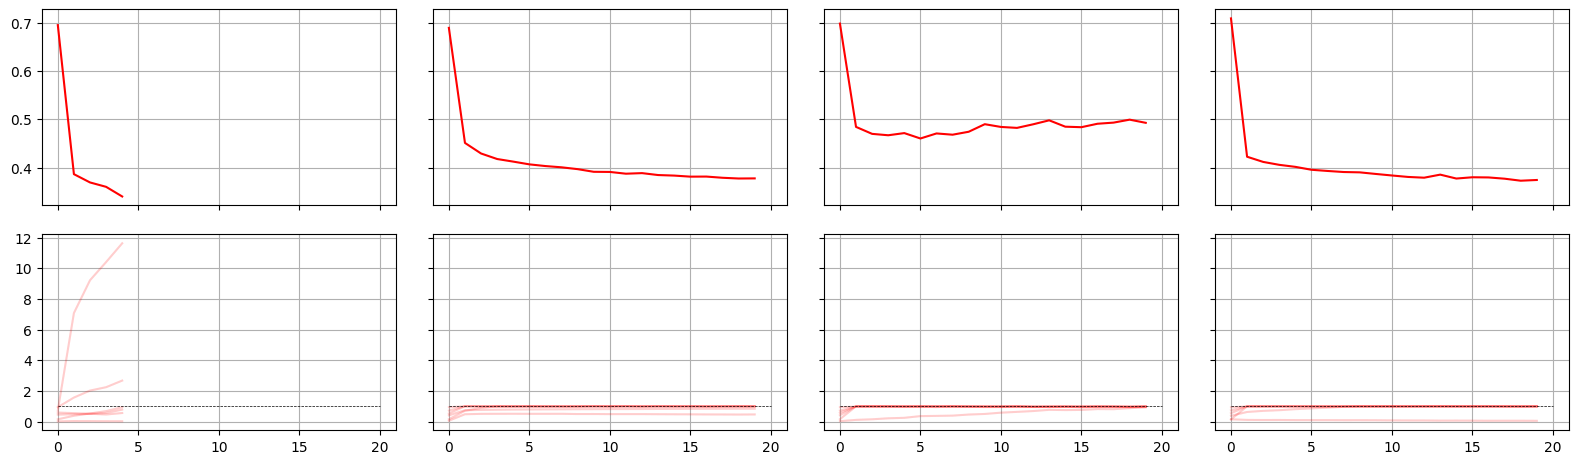

In [ ]:
# import pandas as pd
# from matplotlib import pyplot as plt

# def plot_one_trajectory(trajectory, ax_obj, ax_con, kwargs = {}):
#     ax_obj.plot(trajectory['train_loss'], **kwargs)
#     for c in [c for c in df.columns if c.startswith('c_') and c.endswith('_train')]:
#         ax_con.plot(df[c], **kwargs)
#     for c in [c for c in df.columns if c.startswith('c_') and c.endswith('_train')]:
#         ax_con.plot(df[c], **kwargs)

# def fill_between_quantiles(q1, q2, ax_obj, ax_con, kwargs = {}):
#     q


# def plot_trajectories(histories, quantiles=(0.25, 0.75)):
#     """
#     histories: a dict of lists of DataFrames (multiple algorithms, multiple runs)
#     """
#     # multiple algorithms, multiple runs
#     #  {'adam': [adam, adam, adam], 'alm': [alm, alm, alm], ...}
#     n_algs = len(histories)
#     f, axs = plt.subplots(nrows=2, ncols=n_algs, sharex=True, sharey='row')
#     axs[0][0].set_label('Loss')
#     axs[0][0].set_label('Constraints')
#     for alg_idx, (alg_name, alg_trajectories) in enumerate(histories.items()): # iterate over algorithms
#         alg_trajectories_grouped = pd.concat(alg_trajectories).groupby('epoch')
#         mean = alg_trajectories_grouped.mean()
#         q0 = alg_trajectories_grouped.quantile(quantiles[0])
#         q1 = alg_trajectories_grouped.quantile(quantiles[1])
#         axs[0][alg_idx].set_title(alg_name)
#         plot_one_trajectory(mean, axs[0][alg_idx], axs[1][alg_idx])
#         plot_one_trajectory(q0, axs[0][alg_idx], axs[1][alg_idx], {'ls': '-'})
#         plot_one_trajectory(q1, axs[0][alg_idx], axs[1][alg_idx], {'ls': '-'})

    


# trajectories = [adam.history, alm.history, alm_adam.history, pbm.history]
# f, axs = plt.subplots(nrows=2, ncols=len(trajectories), sharex=True, sharey='row')
# f.set_figwidth(len(trajectories)*4)
# f.tight_layout()
# for plt_idx, df in enumerate([pd.DataFrame(alg) for alg in trajectories]):
#     ax1 = axs[0][plt_idx]
#     ax2 = axs[1][plt_idx]
#     ax1.plot(df['train_loss'], color='red', ls='-')
#     ax1.grid()
#     ax2.grid()
#     for c in [c for c in df.columns if c.startswith('c_') and c.endswith('_train')]:
#         ax2.plot(df[c], color='red', ls='-', alpha=0.1)
#     for c in [c for c in df.columns if c.startswith('c_') and c.endswith('_train')]:
#         ax2.plot(df[c], color='red', ls='-', alpha=0.1)

#     ax2.hlines(bounds[0], 0, 20,ls='--', color='black', lw=0.5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_losses_and_constraints_multi(
    losses_list,
    constraints_list,
    constraint_thresholds,
    losses_std_list=None,
    titles=None,
    plot_individual_constraints=True,
    eval_points=2,
    std_multiplier=2,
):
    """
    Plot loss and constraint values for multiple ML algorithms with min-max, std, and eval points.

    Parameters
    ----------
    losses_list : list of np.ndarray or list of 2D np.ndarray
        Each element is either:
        - 1D array of losses for one algorithm, or
        - 2D array (num_runs x timesteps) for multiple runs.
    constraints_list : list of list of np.ndarray
        Each element is a list of 1D arrays (constraint values for that algorithm).
    constraint_thresholds : np.ndarray or list
        Threshold lines for constraints.
    losses_std_list : list of np.ndarray, optional
        1D array of std per algorithm.
    titles : list of str, optional
        Algorithm names.
    plot_individual_constraints : bool, default True
        Plot individual constraint curves.
    eval_points : int or array-like, default 2
        Epoch indices to mark with symbols.
    std_multiplier : float, default 2
        Multiplier for shading std bands.
    """
    # --- Color palette: Tableau 10 ---
    colors = [
        "#4E79A7",
        "#F28E2B",
        "#E15759",
        "#76B7B2",
        "#59A14F",
        "#EDC948",
        "#B07AA1",
        "#FF9DA7",
        "#9C755F",
        "#BAB0AB",
    ]
    # --- Marker styles ---
    marker_styles = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*"]

    num_algos = len(losses_list)
    if titles is None:
        titles = [f"Algorithm {i + 1}" for i in range(num_algos)]
    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    fig, axes = plt.subplots(2, num_algos, figsize=(5 * num_algos, 8), sharex="col")
    if num_algos == 1:
        axes = np.array([[axes[0]], [axes[1]]])  # consistent 2D indexing

    for j in range(num_algos):
        loss = np.asarray(losses_list[j])
        x = np.arange(loss.shape[-1])
        color = colors[j % len(colors)]

        # --- LOSS PLOT ---
        ax_loss = axes[0, j]
        # Multiple runs: min-max shading
        if loss.ndim == 2:
            loss_mean = np.mean(loss, axis=0)
            loss_min = np.min(loss, axis=0)
            loss_max = np.max(loss, axis=0)
            ax_loss.fill_between(
                x, loss_min, loss_max, color=color, alpha=0.15, label="Mean Loss +- Std"
            )
        else:
            loss_mean = loss

        # Std shading
        if losses_std_list is not None and losses_std_list[j] is not None:
            loss_std = np.asarray(losses_std_list[j])
            ax_loss.fill_between(
                x,
                loss_mean - std_multiplier * loss_std,
                loss_mean + std_multiplier * loss_std,
                color=color,
                alpha=0.25,
                label=f"Loss ± Std",
            )

        # Mean curve
        ax_loss.plot(x, loss_mean, color=color, lw=2, label=titles[j])

        # Eval points
        if eval_points is not None:
            if isinstance(eval_points, int):
                idx = np.arange(0, len(loss_mean), eval_points)
            else:
                idx = np.array(eval_points)
                idx = idx[idx < len(loss_mean)]
            ax_loss.plot(
                x[idx], loss_mean[idx], marker_styles[j], color=color, markersize=6
            )

        ax_loss.set_title(titles[j])
        ax_loss.set_ylabel("Mean Loss")
        ax_loss.grid(True, linestyle="--", alpha=0.35)
        ax_loss.legend(fontsize=9)

        # --- CONSTRAINT PLOT ---
        ax_constr = axes[1, j]
        constraints = np.array(constraints_list[j])
        x = np.arange(constraints.shape[1])
        color = colors[j % len(colors)]

        # Optional: individual constraint curves
        if plot_individual_constraints:
            for c in constraints:
                ax_constr.plot(x, c, color=color, alpha=0.6, lw=1.5)

        # Min-Max band for constraints
        c_min = np.min(constraints, axis=0)
        c_max = np.max(constraints, axis=0)
        ax_constr.fill_between(
            x, c_min, c_max, color=color, alpha=0.15, label="Constraint Range"
        )

        # Threshold lines
        for th in constraint_thresholds:
            ax_constr.axhline(
                th, color="red", linestyle="--", lw=1.4, label="Threshold"
            )

        ax_constr.set_ylabel("Constraint")
        ax_constr.grid(True, linestyle="--", alpha=0.35)
        ax_constr.legend(fontsize=9)

    axes[-1, 0].set_xlabel("Epoch")
    plt.tight_layout()
    plt.show()

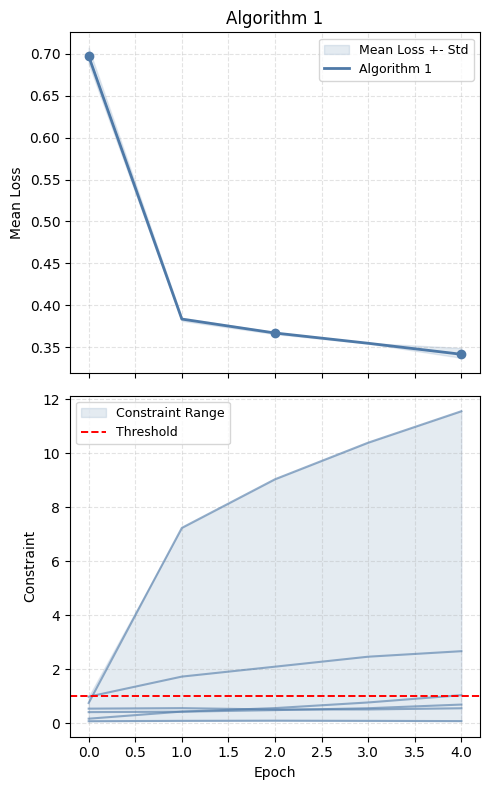

In [ ]:
plot_losses_and_constraints_multi(
    losses_list = [[hist['train_loss']for hist in adam_histories]],
    constraints_list = [np.array(hist[[c for c in hist.columns if c.startswith('c_')]]).T for hist in adam_histories],
    constraint_thresholds=bounds[0]
)

In [ ]:
# save the computed data
np.savez(
    log_path,
    losses=[np.array(Adam_loss_log_plotting)],
    constraints=[np.array(Adam_c_log_plotting).T],
    losses_std=[np.array(Adam_std_loss_log_plotting)],
)

In [ ]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [constraint_bounds[0]]

plot_losses_and_constraints_multi(
    losses,
    constraints,
    thresholds,
    losses_std_list=losses_std,
    titles=["Unconstrained Adam"],
    plot_individual_constraints=True,
    std_multiplier=1,
)

In [ ]:
from humancompatible.train.optim import SSLALM

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1),
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSLALM(params=model.parameters(), m=m, lr=0.01, dual_lr=0.1)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.0] * m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# alloc arrays for plotting
SSL_ALM_loss_log_plotting = []
SSL_ALM_c_log_plotting = []
SSL_ALM_std_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        # calculate constraints and constraint grads - constraint per each weight matrix
        c_log.append([])
        for i, param in enumerate(model.parameters()):
            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality11.559413
            norm_viol = torch.max(norm - constraint_bounds[i], torch.zeros(1))

            # calculate the Jacobian of the constraint
            norm_viol.backward()

            # update the dual variable + save the Jacobian for later - its needed in the primal variable update
            optimizer.dual_step(i, c_val=norm_viol)
            optimizer.zero_grad()

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())

        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()

    # save the epoch values for plotting
    SSL_ALM_loss_log_plotting.append(np.mean(loss_log))
    SSL_ALM_c_log_plotting.append(np.mean(c_log, axis=0))
    SSL_ALM_std_loss_log_plotting.append(np.std(loss_log))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(SSL_ALM_loss_log_plotting)]
constraints += [np.array(SSL_ALM_c_log_plotting).T]
losses_std += [np.array(SSL_ALM_std_loss_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

In [ ]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [constraint_bounds[0]]

plot_losses_and_constraints_multi(
    losses,
    constraints,
    thresholds,
    losses_std_list=losses_std,
    std_multiplier=1,
    titles=["Unconstrained Adam", "SSL-ALM-SGD"],
    plot_individual_constraints=True,
)

#### 2.2 SSL-ALM Adam

In [ ]:
import sys, os

# Add the ../src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1),
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSLALM_Adam(params=model.parameters(), m=m, lr=0.001, dual_lr=0.1)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.0] * m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# alloc arrays for plotting
SSL_ALM_Adam_loss_log_plotting = []
SSL_ALM_Adam_c_log_plotting = []
SSL_ALM_Adam_std_c_log_plotting = []

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        # calculate constraints and constraint grads - constraint per each weight matrix
        c_log.append([])
        for i, param in enumerate(model.parameters()):
            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(norm - constraint_bounds[i], torch.zeros(1))

            # calculate the Jacobian of the constraint
            norm_viol.backward()

            # update the dual variable + save the Jacobian for later - its needed in the primal variable update
            optimizer.dual_step(i, c_val=norm_viol[0])
            optimizer.zero_grad()

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())

        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()

    # save the epoch values for plotting
    SSL_ALM_Adam_loss_log_plotting.append(np.mean(loss_log))
    SSL_ALM_Adam_c_log_plotting.append(np.mean(c_log, axis=0))
    SSL_ALM_Adam_std_c_log_plotting.append(np.std(loss_log))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(SSL_ALM_Adam_loss_log_plotting)]
constraints += [np.array(SSL_ALM_Adam_c_log_plotting).T]
losses_std += [np.array(SSL_ALM_Adam_std_c_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

In [ ]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [constraint_bounds[0]]

plot_losses_and_constraints_multi(
    losses,
    constraints,
    thresholds,
    losses_std_list=losses_std,
    std_multiplier=1,
    titles=["Unconstrained Adam", "SSL-ALM-SGD", "SSL-ALM-Adam"],
    plot_individual_constraints=True,
)

#### 3. Switching-Subgradient

In [ ]:
from humancompatible.train.algorithms import SSG

# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1),
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSG(params=model.parameters(), m=1, lr=0.01, dual_lr=0.1)

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.0]

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# alloc the plotting array
SSG_c_log_plotting = []
SSG_loss_log_plotting = []
SSG_std_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):
    # alloc logging array
    loss_log = []
    c_log = []
    duals_log = []

    # train for all data
    for batch_input, batch_label in dataloader:
        # prepare the max of the violation
        max_norm_viol = torch.zeros(1)
        c_log.append([])

        # calculate constraints and constraint grads - max of constraint per each weight matrix
        for i, param in enumerate(model.parameters()):
            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(norm - constraint_bounds[0], torch.zeros(1))

            # save the max
            max_norm_viol = torch.max(max_norm_viol, norm_viol)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # calculate the Jacobian of the max-violating norm constraint
        max_norm_viol.backward()

        # save the gradient of the constraint
        optimizer.dual_step(0)
        optimizer.zero_grad()

        # calculate loss and grad
        out = model(batch_input)
        loss = criterion(out, batch_label)
        loss.backward()

        # save the loss value
        loss_log.append(loss.detach().numpy())

        # perform a step - either update based on the loss grad or constraint grad
        optimizer.step(max_norm_viol)
        optimizer.zero_grad()

    # save the epoch values for plotting
    SSG_loss_log_plotting.append(np.mean(loss_log))
    SSG_c_log_plotting.append(np.mean(c_log, axis=0))
    SSG_std_loss_log_plotting.append(np.std(loss_log))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(SSG_loss_log_plotting)]
constraints += [np.array(SSG_c_log_plotting).T]
losses_std += [np.array(SSG_std_loss_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

In [ ]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [constraint_bounds[0]]

plot_losses_and_constraints_multi(
    losses,
    constraints,
    thresholds,
    losses_std_list=losses_std,
    std_multiplier=1,
    titles=["Unconstrained Adam", "SSL-ALM-SGD", "SSL-ALM-Adam", "SSG"],
    plot_individual_constraints=True,
)

#### 4. Cooper - Augmented Lagrangian

In [ ]:
# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1),
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.0] * m

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
import cooper

# select device
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cpu"


# define the problem
class ACS_Deterministic_Constr_Fair_ALM(cooper.ConstrainedMinimizationProblem):
    def __init__(self, formulation_type):
        super().__init__()

        # define the number of multipliers - same as the number of constraints
        if not formulation_type.expects_multiplier:
            self.multiplier = None
        else:
            self.multiplier = cooper.multipliers.DenseMultiplier(
                num_constraints=len(list(model.parameters())), device=DEVICE
            )

        # add the penalty coefficient - augmented lagrangian
        if not formulation_type.expects_penalty_coefficient:
            self.penalty = None
        else:
            self.penalty = cooper.penalty_coefficients.DensePenaltyCoefficient(
                init=torch.tensor(1.0, device=DEVICE),
            )

        # inequality constraints on the norm of the matrix
        self.constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.INEQUALITY,
            formulation_type=formulation_type,
            multiplier=self.multiplier,
            penalty_coefficient=self.penalty,
        )

    # function that computes the constraints and the loss function
    def compute_cmp_state(self, model, inputs, targets):
        # compute the yhat loss
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        loss = criterion(model(inputs), targets)

        # calculate constraints
        norm_values_c = []
        for i, param in enumerate(model.parameters()):
            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # compute the violation of the constraint
            norm_viol = norm - constraint_bounds[i]
            norm_values_c.append(norm_viol)

        # compute the constraint violation
        constraint_state = cooper.ConstraintState(violation=torch.stack(norm_values_c))
        observed_constraints = {self.constraint: constraint_state}

        return cooper.CMPState(loss=loss, observed_constraints=observed_constraints)

In [ ]:
# create the problem
problem = ACS_Deterministic_Constr_Fair_ALM(cooper.formulations.AugmentedLagrangian)

# flag of dual variables
has_dual_variables = problem.multiplier is not None

# create the primal optimizer
primal_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create the dual optimizer
if has_dual_variables:
    dual_optimizer = torch.optim.SGD(problem.dual_parameters(), lr=0.1, maximize=True)

    # combine the optimizers
    constrained_optimizer = cooper.optim.SimultaneousOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
        dual_optimizers=dual_optimizer,
    )
else:
    # Formulations without dual variables, such as the Quadratic Penalty
    # formulation, do not require a dual optimizer
    constrained_optimizer = cooper.optim.UnconstrainedOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
    )

# Increase the penalty coefficient by `increment` if the constraint is violate by more
# than `violation_tolerance`- keep this the same - since its not included in SSL-ALM implementation
penalty_scheduler = cooper.penalty_coefficients.AdditivePenaltyCoefficientUpdater(
    increment=0.0,
    violation_tolerance=1e-3,
)

In [ ]:
# alloc arrays for plotting
Cooper_c_log_plotting = []
Cooper_loss_log_plotting = []
Cooper_std_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []
    penalty_coefficient_values = []

    # alloc norm values array
    norm_values_c = []

    # go through all data
    for batch_input, batch_label in dataloader:
        # calculate constraints - just for logging
        c_log.append([])
        for i, param in enumerate(model.parameters()):
            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # compute the loss - just for logging purposes
        loss = criterion(model(batch_input), batch_label)
        loss_log.append(loss.item())

        # compute the states
        compute_cmp_state_kwargs = {
            "model": model,
            "inputs": batch_input,
            "targets": batch_label,
        }
        roll_out = constrained_optimizer.roll(
            compute_cmp_state_kwargs=compute_cmp_state_kwargs
        )

        # Update the penalty coefficient
        constraint_state = roll_out.cmp_state.observed_constraints[problem.constraint]
        penalty_scheduler.update_penalty_coefficient_(
            problem.constraint, constraint_state
        )

        # get the dual variables and the coefficients
        multiplier_value = (
            problem.multiplier.weight.detach().numpy() if has_dual_variables else None
        )
        penalty_coefficient_value = problem.constraint.penalty_coefficient().item()

        # save the duals and penalty coefficients
        duals_log.append(multiplier_value)
        penalty_coefficient_values.append(penalty_coefficient_value)

    # save the epoch values for plotting
    Cooper_loss_log_plotting.append(np.mean(loss_log))
    Cooper_c_log_plotting.append(np.mean(c_log, axis=0))
    Cooper_std_loss_log_plotting.append(np.std(loss_log))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}, "
        f"penalty coefficients: {np.mean(penalty_coefficient_values, axis=0)}, "
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(Cooper_loss_log_plotting)]
constraints += [np.array(Cooper_c_log_plotting).T]
losses_std += [np.array(Cooper_std_loss_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

In [ ]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [constraint_bounds[0]]

plot_losses_and_constraints_multi(
    losses,
    constraints,
    thresholds,
    losses_std_list=losses_std,
    std_multiplier=1,
    titles=["Unconstrained Adam", "SSL-ALM-SGD", "SSL-ALM-Adam", "SSG", "Cooper-ALM"],
    plot_individual_constraints=True,
)

#### 5. CHOP

The library is based on the [Stochastic Franke-Wolfe (SFW)](https://arxiv.org/pdf/2010.07243), which constraints the parameters on a convex set. Thus, the model weights are to be in a closed ball, simplex and such. This can only be used for the determinitic case of benchmarking but cannot be extended to the stochastic constrained case. 

NOTE: The repo has an error in it. <code>chop/constraints.py</code>, line 292: 

<code>update_direction = iterate.clone().detach()</code> change to 

<code>update_direction = -iterate.clone().detach()</code>

In [ ]:
import chop

# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1),
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.0]

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# create an optimizer with a ball constraints
optimizer = chop.stochastic.FrankWolfe(
    model.parameters(),
    chop.constraints.L2Ball(alpha=constraint_bounds[0]),
    lr=0.001,
    momentum=0.9,
    normalization="gradient",
)

bias_params = [param for name, param in model.named_parameters() if "bias" in name]
bias_opt = chop.stochastic.PGD(
    bias_params, chop.constraints.L2Ball(alpha=constraint_bounds[0]), lr=0.001
)

# project the model weights into the feasible region (an assumption of the franke-wolfe)
for i, param in enumerate(model.parameters()):
    param_proj = chop.constraints.L2Ball(alpha=constraint_bounds[0]).prox(param)

    # Update the parameter in-place
    with torch.no_grad():
        param.copy_(param_proj)

In [ ]:
# alloc arrays for plotting
CHOP_c_log_plotting = []
CHOP_loss_log_plotting = []
CHOP_std_loss_log_plotting = []

model.train()

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # alloc norm values array
    norm_values_c = []

    # go through all data
    for batch_input, batch_label in dataloader:
        # calculate constraints - just for logging
        c_log.append([])
        for i, param in enumerate(model.parameters()):
            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # compute the loss - just for logging purposes
        optimizer.zero_grad()
        bias_opt.zero_grad()
        loss = criterion(model(batch_input), batch_label)
        loss.backward()
        optimizer.step()
        bias_opt.step()

        # save the loss for later
        loss_log.append(loss.item())

    # save the epoch values for plotting
    CHOP_loss_log_plotting.append(np.mean(loss_log))
    CHOP_c_log_plotting.append(np.mean(c_log, axis=0))
    CHOP_std_loss_log_plotting.append(np.std(loss_log))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(CHOP_loss_log_plotting)]
constraints += [np.array(CHOP_c_log_plotting).T]
losses_std += [np.array(CHOP_std_loss_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

#### 6. Penalty/Barrier Method (PBM)

PBM can only handle inequality constraints. That is, the problem of type: 

\begin{aligned}
& \min_{x \in \mathbb{R}^n} \; \mathbb{E}[f(x,\xi)] \\
& \text{s.t.} \quad \mathbb{E}[c(x,\zeta)] \le 0. \quad
\end{aligned}

Which means, there is no need to introduce the slack variables. 

In [ ]:
import sys
!{sys.executable} -m pip install ../

In [ ]:
import sys, os
import subprocess
# Add the ../src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.humancompatible.train.optim.PBM import PBM

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1),
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = PBM(params=model.parameters(), m=m, lr=0.001, dual_beta=0.95, penalty_update_m='CONST', barrier="quadratic_logarithmic")

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.0] * m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# alloc arrays for plotting
SSL_ALM_Adam_loss_log_plotting = []
SSL_ALM_Adam_c_log_plotting = []
SSL_ALM_Adam_std_c_log_plotting = []

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        # calculate constraints and constraint grads - constraint per each weight matrix
        c_log.append([])
        for i, param in enumerate(model.parameters()):
            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # copmute the constraint
            norm_viol = norm - constraint_bounds[i]
            
            # update the dual variable + save the Jacobian for later - its needed in the primal variable update
            optimizer.dual_step(i, c_val=norm_viol)
            optimizer.zero_grad()

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())

        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()

    # save the epoch values for plotting
    SSL_ALM_Adam_loss_log_plotting.append(np.mean(loss_log))
    SSL_ALM_Adam_c_log_plotting.append(np.mean(c_log, axis=0))
    SSL_ALM_Adam_std_c_log_plotting.append(np.std(loss_log))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])

# append
losses += [np.array(SSL_ALM_Adam_loss_log_plotting)]
constraints += [np.array(SSL_ALM_Adam_c_log_plotting).T]
losses_std += [np.array(SSL_ALM_Adam_std_c_log_plotting)]

# save the computed data
np.savez(log_path, losses=losses, constraints=constraints, losses_std=losses_std)

#### Results

We first plot all algorithms separately. This makes it easy to see the violation of each constraint.

In [ ]:
# plot the current results
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
losses_std = np.load(log_path)["losses_std"]
thresholds = [constraint_bounds[0]]

plot_losses_and_constraints_multi(
    losses,
    constraints,
    thresholds,
    losses_std_list=losses_std,
    std_multiplier=1,
    titles=[
        "Unconstrained Adam",
        "SSL-ALM-SGD",
        "SSL-ALM-Adam",
        "SSG",
        "Cooper-ALM",
        "SFW",
        "PBM"
    ],
    plot_individual_constraints=True,
)

To better compare the results, we plot all losses in a single Figure.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_losses_and_constraints_single(
    losses_list,
    losses_std_list,
    constraints_list,
    constraint_thresholds,
    titles=None,
    eval_points=2,
    std_multiplier=2,
    log_constraints=False,
    log_loss=False,
):
    # --- Color palette: Tableau 10 ---
    colors = [
        "#4E79A7",
        "#F28E2B",
        "#E15759",
        "#76B7B2",
        "#59A14F",
        "#EDC948",
        "#B07AA1",
        "#FF9DA7",
        "#9C755F",
        "#BAB0AB",
    ]

    # --- Marker styles (reused from inspired function) ---
    marker_styles = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*"]
    marker_styles = (marker_styles * ((len(losses_list) // len(marker_styles)) + 1))[
        : len(losses_list)
    ]

    num_algos = len(losses_list)
    if titles is None:
        titles = [f"Algorithm {i + 1}" for i in range(num_algos)]
    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    fig, axes = plt.subplots(2, 1, figsize=(9, 11))
    ax_loss, ax_constr = axes

    # --- LOSS PLOT ---
    for j, (loss, loss_std) in enumerate(zip(losses_list, losses_std_list)):
        x = np.arange(len(loss))
        color = colors[j % len(colors)]

        if log_loss:
            loss = np.log(loss)

        upper = loss + std_multiplier * loss_std
        lower = loss - std_multiplier * loss_std

        # Mean curve
        ax_loss.plot(x, loss, lw=2.8, color=color, label=titles[j])
        # Std shading
        ax_loss.fill_between(x, lower, upper, color=color, alpha=0.09)

        # Eval points
        if eval_points is not None:
            if isinstance(eval_points, int):
                idx = np.arange(0, len(loss), eval_points)
            else:
                idx = np.array(eval_points)
                idx = idx[idx < len(loss)]
            ax_loss.plot(
                x[idx],
                loss[idx],
                marker_styles[j],
                color=color,
                markersize=7,
                alpha=0.9,
            )

    ax_loss.set_ylabel("Mean Loss")
    ax_loss.set_title("Loss Comparison")
    ax_loss.grid(True, linestyle="--", alpha=0.35)
    ax_loss.legend(fontsize=9)

    # --- CONSTRAINT PLOT ---
    for j, constraints in enumerate(constraints_list):
        color = colors[j % len(colors)]

        # to make smooth constraints
        eval_points = 1

        if log_constraints:
            constraints = np.log(np.array(constraints))
        x = np.arange(constraints.shape[1])

        c_min = np.min(constraints, axis=0)
        c_max = np.max(constraints, axis=0)

        # Fill min-max range
        ax_constr.fill_between(x, c_min, c_max, color=color, alpha=0.1, label=titles[j])

        # Plot mean curves with markers
        for c_mean in constraints:
            # ax_constr.plot(x, c_mean, lw=0.3, color=color, alpha=0.01)
            if eval_points is not None:
                if isinstance(eval_points, int):
                    idx = np.arange(0, len(c_mean), eval_points)
                else:
                    idx = np.array(eval_points)
                    idx = idx[idx < len(c_mean)]
                ax_constr.plot(
                    x[idx],
                    c_mean[idx],
                    # marker_styles[j],
                    color=color,
                    # markersize=5,
                    lw=0.7,
                    alpha=0.6,
                )

    # Threshold lines
    for th in constraint_thresholds:
        y = np.log(th) if log_constraints else th
        ax_constr.axhline(y, color="red", linestyle="--", lw=1.4, label="Threshold")

    ax_constr.set_ylabel("Log Constraint" if log_constraints else "Constraint")
    ax_constr.set_xlabel("Epoch")
    ax_constr.set_title("Constraint Comparison")
    ax_constr.grid(True, linestyle="--", alpha=0.35)
    ax_constr.legend(fontsize=9)

    plt.tight_layout()
    plt.show()

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
thresholds = [constraint_bounds[0]]

plot_losses_and_constraints_single(
    losses,
    losses_std,
    constraints,
    thresholds,
    log_constraints=True,
    log_loss=False,
    titles=[
        "Unconstrained Adam",
        "SSL-ALM-SGD",
        "SSL-ALM-Adam",
        "SSG",
        "Cooper-ALM",
        "SFW",
        "PBM"
    ],
)

Note the unconstrained Adam is in this case superior to the constrained optimization in terms of the regression loss. This is due to the high restriction of the constraints.

# Stochastic constraints: ACSIncome - Uniform Positive Rate 

To benchmark the stochastic constraints, we define the regression problem for binary classification of income above a threshold as

\begin{aligned}
& \min_{x \in \mathbb{R}^n} \; \mathbb{E}[f(x,\xi)] \\
& \text{s.t.} \quad \mathbb{E}[c(x,\zeta)] \le 0, \quad
\end{aligned}

where the $f: \mathbb{R}^n \times Ξ \rightarrow \mathbb{R}$ is a loss, the constraint $c : \mathbb{R}^n \times Z \rightarrow \mathbb{R}$ is a norm of positive rate fair metric among the sensitive groups of $S = \{$ man, woman $\}$, of size $k=2$. That is, we aim to have an unbiased regression model $g$ that has the property of

\begin{aligned}
\forall S_k \in S :\; P\big(g(x, \zeta_i) = 1 \mid S_k = 1\big)
= P\big(g(x, \zeta_i) = 1\big).
\end{aligned}

Such statistics gives us a violation vector $\bold{v} \in \mathbb{R}^k$, we define the constraint as $c(x, \zeta) = || \bold{v}(x, \zeta) ||_p$. We choose a Manhatton $p=1$. For more details about the fairness metrics see [Fairret](https://openreview.net/pdf?id=NnyD0Rjx2B). Such model should be good at classification while maintaining the fairness among sensitive demographics groups.

#### 1. Unconstrained Optimization

In [ ]:
# define the torch seed here
seed_n = 1
n_epochs = 60

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# log path file
log_path = "./data/logs/log_benchmark_stochastic.npz"

In [ ]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=128, drop_last=True
)
# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

# define the criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2  # define the bound on the criterion

In [ ]:
import torch
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1),
)

# create the SSLALM optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# alloc arrays for plotting
Adam_S_loss_log_plotting = []  # mean
Adam_S_c_log_plotting = []  # mean
Adam_S_loss_std_log_plotting = []  # std
Adam_S_c_std_log_plotting = []  # std

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model(batch_input)
        fair_loss = fair_criterion(out, batch_sens)

        # calculate the fair constraint violation
        fair_constraint = fair_loss

        # save the fair loss violation for logging
        c_log.append([fair_loss.detach().item()])

        # calculate primal loss and grad
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

    Adam_S_c_log_plotting.append(np.mean(c_log, axis=0))
    Adam_S_loss_log_plotting.append(np.mean(loss_log))
    Adam_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    Adam_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_losses_and_constraints_single_stochastic(
    losses_list,
    losses_std_list,
    constraints_list,
    constraints_std_list,
    constraint_thresholds,
    titles=None,
    eval_points=2,
    std_multiplier=2,
    log_constraints=False,
):
    # --- Color palette: Tableau 10 ---
    colors = [
        "#4E79A7",
        "#F28E2B",
        "#E15759",
        "#76B7B2",
        "#59A14F",
        "#EDC948",
        "#B07AA1",
        "#FF9DA7",
        "#9C755F",
        "#BAB0AB",
    ]

    # --- Marker styles (reused from inspired function) ---
    marker_styles = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*"]
    marker_styles = (marker_styles * ((len(losses_list) // len(marker_styles)) + 1))[
        : len(losses_list)
    ]

    num_algos = len(losses_list)
    if titles is None:
        titles = [f"Algorithm {i + 1}" for i in range(num_algos)]
    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    fig, axes = plt.subplots(2, 1, figsize=(9, 11))
    ax_loss, ax_constr = axes

    # --- LOSS PLOT ---
    for j, (loss, loss_std) in enumerate(zip(losses_list, losses_std_list)):
        x = np.arange(len(loss))
        color = colors[j % len(colors)]
        upper = loss + std_multiplier * loss_std
        lower = loss - std_multiplier * loss_std

        # Mean curve
        ax_loss.plot(x, loss, lw=2.2, color=color, label=titles[j])
        # Std shading
        ax_loss.fill_between(x, lower, upper, color=color, alpha=0.15)

        # Eval points
        if eval_points is not None:
            if isinstance(eval_points, int):
                idx = np.arange(0, len(loss), eval_points)
            else:
                idx = np.array(eval_points)
                idx = idx[idx < len(loss)]
            ax_loss.plot(
                x[idx],
                loss[idx],
                marker_styles[j],
                color=color,
                markersize=6,
                alpha=0.8,
            )

    ax_loss.set_ylabel("Mean Loss")
    ax_loss.set_title("Loss Comparison")
    ax_loss.grid(True, linestyle="--", alpha=0.35)
    ax_loss.legend(fontsize=9)

    # --- CONSTRAINT PLOT ---
    for j, (constraints, constraints_std) in enumerate(
        zip(constraints_list, constraints_std_list)
    ):
        color = colors[j % len(colors)]
        constraints = np.array(constraints)
        constraints_std = np.array(constraints_std)
        x = np.arange(constraints.shape[1])

        c_min = np.min(constraints - std_multiplier * constraints_std, axis=0)
        c_max = np.max(constraints + std_multiplier * constraints_std, axis=0)

        # Fill min-max range
        ax_constr.fill_between(
            x, c_min, c_max, color=color, alpha=0.15, label=titles[j]
        )

        # Plot mean curves with markers
        for c_mean in constraints:
            ax_constr.plot(x, c_mean, lw=1.8, color=color, alpha=0.7)
            if eval_points is not None:
                if isinstance(eval_points, int):
                    idx = np.arange(0, len(c_mean), eval_points)
                else:
                    idx = np.array(eval_points)
                    idx = idx[idx < len(c_mean)]
                ax_constr.plot(
                    x[idx],
                    c_mean[idx],
                    marker_styles[j],
                    color=color,
                    markersize=5,
                    alpha=0.8,
                )

    # Threshold lines
    for th in constraint_thresholds:
        y = np.log(th) if log_constraints else th
        ax_constr.axhline(y, color="red", linestyle="--", lw=1.4, label="Threshold")

    ax_constr.set_ylabel("Log Constraint" if log_constraints else "Constraint")
    ax_constr.set_xlabel("Epoch")
    ax_constr.set_title("Constraint Comparison")
    ax_constr.grid(True, linestyle="--", alpha=0.35)
    ax_constr.legend(fontsize=9)

    plt.tight_layout()
    plt.show()

In [ ]:
# save the computed data
np.savez(
    log_path,
    losses=[np.array(Adam_S_loss_log_plotting)],
    constraints=[np.array(Adam_S_c_log_plotting).T],
    losses_std=[np.array(Adam_S_loss_std_log_plotting)],
    constraints_std=[np.array(Adam_S_c_std_log_plotting).T],
)

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [fair_crit_bound]

plot_losses_and_constraints_single_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    thresholds,
    titles=["Unconstrained Adam"],
    log_constraints=False,
    std_multiplier=1,
)

#### 2.1 SSL-ALM SGD

In [ ]:
from humancompatible.train.algorithms import SSLALM
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

optimizer = SSLALM(
    params=model_con.parameters(),
    m=1,  # number of constraints - one in our case
    lr=0.1,  # primal variable lr
    dual_lr=0.05,  # lr of a dual ALM variable
    dual_bound=5,
    rho=1,  # rho penalty in ALM parameter
    mu=2,  # smoothing parameter
)

# add slack variables - to create the equality from the inequalities
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

In [ ]:
# alloc arrays for plotting
SSLALM_SGD_S_loss_log_plotting = []  # mean
SSLALM_SGD_S_c_log_plotting = []  # mean
SSLALM_SGD_S_loss_std_log_plotting = []  # std
SSLALM_SGD_S_c_std_log_plotting = []  # std

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)

        # calculate the fair constraint violation
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)

        # perform the dual step variable + save the dual grad for later
        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        # save the fair loss violation for logging
        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())

        # calculate primal loss and grad
        loss = (
            criterion(out, batch_label) + 0 * slack_vars[0]
        )  # need to add 0*slack variables for autograd to work
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()

    optimizer.dual_lr *= 0.95
    SSLALM_SGD_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSLALM_SGD_S_loss_log_plotting.append(np.mean(loss_log))
    SSLALM_SGD_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSLALM_SGD_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])

# append
losses += [np.array(SSLALM_SGD_S_loss_log_plotting)]
constraints += [np.array(SSLALM_SGD_S_c_log_plotting).T]
losses_std += [np.array(SSLALM_SGD_S_loss_std_log_plotting)]
constraints_std += [np.array(SSLALM_SGD_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
)

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [fair_crit_bound]

plot_losses_and_constraints_single_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    thresholds,
    titles=["Unconstrained Adam", "SSL-ALM-SGD"],
    log_constraints=False,
    std_multiplier=1,
)

#### 2.2 SSL-ALM Adam

In [ ]:
from torch.nn import Sequential
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)
    
optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=1,  # number of constraints - one in our case
    lr=0.01,  # primal variable lr
    dual_lr=0.05,  # lr of a dual ALM variable
    dual_bound=5,
    rho=1,  # rho penalty in ALM parameter
    mu=2,  # smoothing parameter
)

# add slack variables - to create the equality from the inequalities    
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

In [ ]:
# alloc arrays for plotting
SSLALM_S_loss_log_plotting = []  # mean
SSLALM_S_c_log_plotting = []  # mean
SSLALM_S_loss_std_log_plotting = []  # std
SSLALM_S_c_std_log_plotting = []  # std

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)

        # calculate the fair constraint violation
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)

        # perform the dual step variable + save the dual grad for later
        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        # save the fair loss violation for logging
        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())

        # calculate primal loss and grad
        loss = criterion(out, batch_label) + 0 * slack_vars[0]
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()

    optimizer.dual_lr *= 0.95
    SSLALM_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSLALM_S_loss_log_plotting.append(np.mean(loss_log))
    SSLALM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSLALM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])

# append
losses += [np.array(SSLALM_S_loss_log_plotting)]
constraints += [np.array(SSLALM_S_c_log_plotting).T]
losses_std += [np.array(SSLALM_S_loss_std_log_plotting)]
constraints_std += [np.array(SSLALM_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
)

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [fair_crit_bound]

plot_losses_and_constraints_single_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    thresholds,
    titles=["Unconstrained Adam", "SSL-ALM-SGD", "SSL-ALM-Adam"],
    log_constraints=False,
    std_multiplier=1,
)

#### 3. Switching-Subgradient

In [ ]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=128, drop_last=True
)

# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

# define the criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [ ]:
from humancompatible.train.algorithms import SSG
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# same network size for all algorithms
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

optimizer = SSG(params=model_con.parameters(), m=1, lr=0.1, dual_lr=0.05)

In [ ]:
# alloc arrays for plotting
SSG_S_loss_log_plotting = []  # mean
SSG_S_c_log_plotting = []  # mean
SSG_S_loss_std_log_plotting = []  # std
SSG_S_c_std_log_plotting = []  # std

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = torch.max(fair_loss - fair_crit_bound, torch.zeros(1))
        fair_constraint.backward(retain_graph=True)

        # compute the grad of the constraints
        optimizer.dual_step(0)
        optimizer.zero_grad()

        # save the constraint value
        c_log.append([fair_loss.detach().item()])

        # calculate loss and grad
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step(fair_constraint)
        optimizer.zero_grad()

    SSG_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSG_S_loss_log_plotting.append(np.mean(loss_log))
    SSG_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSG_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])

# append
losses += [np.array(SSG_S_loss_log_plotting)]
constraints += [np.array(SSG_S_c_log_plotting).T]
losses_std += [np.array(SSG_S_loss_std_log_plotting)]
constraints_std += [np.array(SSG_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
)

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [fair_crit_bound]

plot_losses_and_constraints_single_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    thresholds,
    titles=["Unconstrained Adam", "SSL-ALM-SGD", "SSL-ALM-Adam", "SSG"],
    log_constraints=False,
    std_multiplier=1,
)

#### 4. Cooper - Augmented Lagrangian

In [ ]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=128, drop_last=True
)

# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

# define the criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [ ]:
import torch
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1),
)

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
import cooper

# select device
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # define GPU if available
DEVICE = "cpu"


# define the problem
class ACS_Deterministic_Constr_Fair_ALM(cooper.ConstrainedMinimizationProblem):
    def __init__(self, formulation_type):
        super().__init__()

        # define the number of multipliers - same as the number of constraints
        if not formulation_type.expects_multiplier:
            self.multiplier = None
        else:
            self.multiplier = cooper.multipliers.DenseMultiplier(
                num_constraints=1, device=DEVICE
            )

        # add the penalty coefficient - augmented lagrangian
        if not formulation_type.expects_penalty_coefficient:
            self.penalty = None
        else:
            self.penalty = cooper.penalty_coefficients.DensePenaltyCoefficient(
                init=torch.tensor(1.0, device=DEVICE),
            )

        # inequality constraints on the norm of the matrix
        self.constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.INEQUALITY,
            formulation_type=formulation_type,
            multiplier=self.multiplier,
            penalty_coefficient=self.penalty,
        )

    # function that computes the constraints and the loss function
    def compute_cmp_state(self, model, inputs, targets, batch_sens):
        # compute the yhat loss
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        out = model(inputs)
        loss = criterion(out, targets)

        # compute fair metric
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = fair_loss - fair_crit_bound

        # compute the constraint violation
        constraint_state = cooper.ConstraintState(violation=fair_constraint)
        observed_constraints = {self.constraint: constraint_state}

        return cooper.CMPState(loss=loss, observed_constraints=observed_constraints)

In [ ]:
# create the problem
problem = ACS_Deterministic_Constr_Fair_ALM(cooper.formulations.AugmentedLagrangian)

# flag of dual variables
has_dual_variables = problem.multiplier is not None

# create the primal optimizer
primal_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# create the dual optimizer
if has_dual_variables:
    dual_optimizer = torch.optim.SGD(problem.dual_parameters(), lr=0.05, maximize=True)

    # combine the optimizers
    constrained_optimizer = cooper.optim.SimultaneousOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
        dual_optimizers=dual_optimizer,
    )
else:
    # Formulations without dual variables, such as the Quadratic Penalty
    # formulation, do not require a dual optimizer
    constrained_optimizer = cooper.optim.UnconstrainedOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
    )

# Increase the penalty coefficient by `increment` if the constraint is violate by more
# than `violation_tolerance`- keep this the same - since its not included in SSL-ALM implementation
penalty_scheduler = cooper.penalty_coefficients.AdditivePenaltyCoefficientUpdater(
    increment=0.0,
    violation_tolerance=1e-3,
)

In [ ]:
# alloc arrays for plotting
Cooper_S_c_log_plotting = []
Cooper_S_loss_log_plotting = []
Cooper_S_loss_std_log_plotting = []
Cooper_S_c_std_log_plotting = []

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []
    penalty_coefficient_values = []

    # alloc norm values array
    norm_values_c = []

    # go through all data
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate the constraints - for logging purposes
        out = model(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = fair_loss - fair_crit_bound
        c_log.append([fair_loss.detach().item()])

        # compute the loss - just for logging purposes
        loss = criterion(out, batch_label)
        loss_log.append(loss.item())

        # compute the states
        compute_cmp_state_kwargs = {
            "model": model,
            "inputs": batch_input,
            "targets": batch_label,
            "batch_sens": batch_sens,
        }
        roll_out = constrained_optimizer.roll(
            compute_cmp_state_kwargs=compute_cmp_state_kwargs
        )

        # Update the penalty coefficient
        constraint_state = roll_out.cmp_state.observed_constraints[problem.constraint]
        penalty_scheduler.update_penalty_coefficient_(
            problem.constraint, constraint_state
        )

        # get the dual variables and the coefficients
        multiplier_value = (
            problem.multiplier.weight.detach().numpy() if has_dual_variables else None
        )
        penalty_coefficient_value = problem.constraint.penalty_coefficient().item()

        # save the duals and penalty coefficients
        duals_log.append(multiplier_value)
        penalty_coefficient_values.append(penalty_coefficient_value)

    # save the epoch values for plotting
    Cooper_S_loss_log_plotting.append(np.mean(loss_log))
    Cooper_S_c_log_plotting.append(np.mean(c_log, axis=0))
    Cooper_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    Cooper_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}, "
        f"penalty coefficients: {np.mean(penalty_coefficient_values, axis=0)}, "
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])

# append
losses += [np.array(Cooper_S_loss_log_plotting)]
constraints += [np.array(Cooper_S_c_log_plotting).T]
losses_std += [np.array(Cooper_S_loss_std_log_plotting)]
constraints_std += [np.array(Cooper_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
)

#### 5. PBM

In [ ]:
from humancompatible.train.optim.PBM import PBM

# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1),
)

# create the PBM optimizer
optimizer = PBM(params=model.parameters(), m=1, lr=0.001, dual_beta=0.95, mu=0.1, penalty_update_m='CONST', barrier="quadratic_logarithmic")

# define the criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

# alloc arrays for plotting
SSG_S_loss_log_plotting = []  # mean
SSG_S_c_log_plotting = []  # mean
SSG_S_loss_std_log_plotting = []  # std
SSG_S_c_std_log_plotting = []  # std

In [ ]:
# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = fair_loss - fair_crit_bound

        # compute the grad of the constraints
        optimizer.dual_step(0, fair_constraint)
        optimizer.zero_grad()

        # save the constraint value
        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())

        # calculate loss and grad
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

    SSG_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSG_S_loss_log_plotting.append(np.mean(loss_log))
    SSG_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSG_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])

# append
losses += [np.array(SSG_S_loss_log_plotting)]
constraints += [np.array(SSG_S_c_log_plotting).T]
losses_std += [np.array(SSG_S_loss_std_log_plotting)]
constraints_std += [np.array(SSG_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
)

#### Results

Now we plot all results in a single table to compare all algorithms.

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [fair_crit_bound]

plot_losses_and_constraints_single_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    thresholds,
    titles=[
        "Unconstrained Adam",
        "SSL-ALM-SGD",
        "SSL-ALM-Adam",
        "SSG",
        "Cooper-ALM-IS",
        "PBM"
    ],
    log_constraints=False,
    std_multiplier=1,
)

It is interesting to see that in the stochastic case, the constraints are not as restrictive as in the deterministic case, directly implying the small difference in the loss between the Unconstrained Adam and the best constrained SSL-ALM-Adam.

# Stochastic Constraints: ACSIncome - Equal Opportunity

TODO: add test constr + loss

To benchmark a more complicated problem, we define the regression problem for binary classification of income above a threshold as

\begin{aligned}
& \min_{x \in \mathbb{R}^n} \; \mathbb{E}[f(x,\xi)] \\
& \text{s.t.} \quad \mathbb{E}[c(x,\zeta)] \le 0, \quad
\end{aligned}

where the $f: \mathbb{R}^n \times Ξ \rightarrow \mathbb{R}$ is a loss, the constraint $c : \mathbb{R}^n \times Z \rightarrow \mathbb{R}^m$ is the equal opportunity of the sensitive groups of $S = \{$ man, woman, (married / divorced / single) $\}$ of size $k$. That is, we aim to have an unbiased regression model $g$ that has the property of

\begin{aligned}
\forall S_k, S_j \in S, S_j \neq S_k :\; | \mathbb{E}\big(g(x, \zeta_i) = 1 \mid S_k = 1\big) - \mathbb{E}\big(g(x, \zeta_i) = 1\mid S_j = 1\big)| \leq \epsilon.
\end{aligned}

The number of constraints in this case is of order $\mathcal{O}(k^2)$. Concretely, $k=6$ and so $m=30$. 

In [ ]:
import torch

# define the torch seed here
seed_n = 1
n_epochs = 60

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# log path file
log_path = "./data/logs/log_benchmark_stochastic_2.npz"

In [ ]:
import numpy as np

# resave the path
np.savez(
    log_path,
    losses=[],
    constraints=[],
    losses_std=[],
    constraints_std=[],
)

In [ ]:
# load and prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories
from itertools import product

# load folktables data
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(
    features=ACSIncome.features, definition_df=definition_df
)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(
    acs_data, categories=categories, dummies=True
)

# split the data on groups, labels and features - the features should not have the sensitive feature
sens_cols = [
    "SEX_Female",
    "SEX_Male",
    "MAR_Divorced",
    "MAR_Married",
    "MAR_Never married or under 15 years old",
]
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")

# Split columns into sex and marital
sex_cols = ["SEX_Female", "SEX_Male"]
mar_cols = [
    "MAR_Divorced",
    "MAR_Married",
    "MAR_Never married or under 15 years old",
]

# Convert each row to sex index and marital index
sex_idx = df_feat[sex_cols].values.argmax(axis=1)
mar_idx = df_feat[mar_cols].values.argmax(axis=1)

# Number of unique combinations
num_groups = len(sex_cols) * len(mar_cols)

# Map each combination to a unique index
group_indices = sex_idx * len(mar_cols) + mar_idx  # shape: (num_samples,)

# One-hot encode the combinations
groups_onehot = np.eye(num_groups)[group_indices]

# Create dictionary mapping index to combination
group_dict = {}
for i, (s, m) in enumerate(product(sex_cols, mar_cols)):
    group_dict[i] = f"{s} + {m}"

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups_onehot, test_size=0.2, random_state=42
)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# print the statistics
for idx in group_dict:
    print(f"{group_dict[idx]}, : {(groups_onehot[:, idx] == 1).sum()}")

In [ ]:
# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train, dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# make into a pytorch dataset, remove the sensitive attribute
features_test = torch.tensor(X_test, dtype=torch.float32)
labels_test = torch.tensor(y_test, dtype=torch.float32)
sens_test = torch.tensor(groups_test)
dataset_test = torch.utils.data.TensorDataset(features_test, sens_test, labels_test)

In [ ]:
from fairret.statistic.linear_fractional import PositiveRate

def positive_rate(out_batch, batch_sens, prob_f=torch.nn.functional.sigmoid):
    """
    Calculates the positive rate vector based on the given outputs of the model for the given groups. 
    
    """
    # compute the probabilities - using sigmoid (since that is used )
    if prob_f is None: 
        preds = out_batch
    else: 
        preds = prob_f( out_batch )
    pr = PositiveRate()
    probs_per_group = pr(preds, batch_sens)  # P(y=1|Sk = 1)
    return probs_per_group

In [ ]:
### SETUP FOR BENCHMARK TASK - common elements for all optimizers
from humancompatible.train.benchmark.algorithms.optim_wrapper import OptimLoopWrapper
from humancompatible.train.fairness.utils import BalancedBatchSampler
from torch.nn import Sequential
import torch
latent_size1 = 64
latent_size2 = 32
def create_model():
    model = Sequential(
        torch.nn.Linear(features_train.shape[1], latent_size1),
        torch.nn.ReLU(),
        torch.nn.Linear(latent_size1, latent_size2),
        torch.nn.ReLU(),
        torch.nn.Linear(latent_size2, 1),
    )    
    return model

m = 30 # number of constraints
torch.manual_seed(seed_n)
criterion = torch.nn.BCEWithLogitsLoss()
bounds = [0.1]*m
# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=120, drop_last=True,extend_groups=[0,2,3,5]
)
dataloader = torch.utils.data.DataLoader(dataset_train, sampler=sampler)

# function to calculate the constraints
def groupwise_posrate_constraint(out, batch_sens):
    pos_rate_pergroup = positive_rate(out, batch_sens, prob_f=torch.nn.functional.sigmoid)
    # compute the equal opportunity constraint
    constraints = []
    current_constr = 0
    for i in range(0, len(pos_rate_pergroup)):
        for j in range(0, len(pos_rate_pergroup)):
            if i != j:
                constr_ij = pos_rate_pergroup[i] - pos_rate_pergroup[j]
                constraints.append(constr_ij)
                current_constr += 1
    return constraints

# forward function: expects to have (model, batch) as arguments
def fwd_unconstrained(model, batch):
    batch_inputs, _, batch_labels = batch
    out = model(batch_inputs)
    loss = criterion(out, batch_labels)
    return loss

def fwd_constrained(model, batch, slack_vars = None):
    if slack_vars is not None:
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()
    batch_inputs, batch_sens, batch_labels = batch
    # for some unrelated reason theres an extra dimension in the batch?????
    batch_inputs, batch_sens, batch_labels = batch_inputs[0], batch_sens[0], batch_labels[0]
    out = model(batch_inputs)
    loss = criterion(out, batch_labels)
    constraints = groupwise_posrate_constraint(out, batch_sens)
    if slack_vars:
        constraints_bounded_eq = [con - bounds[i] + slack_vars[i] for i, con in enumerate(constraints)]
    else:
        constraints_bounded_eq = [torch.max(con - bounds[i], torch.zeros_like(con)).to(torch.float) for i, con in enumerate(constraints)]
    return loss, constraints_bounded_eq


# ssw has an old api, so need to redefine some stuff
def fwd_ssw(model, batch):
    batch_inputs, batch_sens, batch_labels = batch
    # for some unrelated reason theres an extra dimension in the batch?????
    batch_inputs, batch_sens, batch_labels = batch_inputs[0], batch_sens[0], batch_labels[0]
    out = model(batch_inputs)
    loss = criterion(out, batch_labels)
    constraints = groupwise_posrate_constraint(out, batch_sens)
    constraints_bounded_eq = torch.max(max([con - bounds[i] for i, con in enumerate(constraints)]), torch.zeros(1))
    return loss, constraints_bounded_eq

def train_iter_ssw(optimizer, model, batch):
    loss, constraint = fwd_ssw(model, batch)
    constraint.backward(retain_graph=True)
    optimizer.dual_step(0)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step(constraint)
    optimizer.zero_grad(set_to_none=True)


@torch.inference_mode
def eval(model, batch):
    inputs, sens, labels = batch
    out = model(inputs)
    loss = criterion(out, labels)
    constraints = groupwise_posrate_constraint(out, sens)
    constraints = [c.detach().numpy().item() for c in constraints]
    return loss.detach().numpy().item(), constraints

In [ ]:
# Adam
model = create_model()
# first backward pass sometimes takes ages
model(features_train[0]).backward()
model.zero_grad()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

adam = OptimLoopWrapper(
    model = model,
    fwd = fwd_unconstrained,
    eval = eval,
    train_data = dataloader,
    eval_data = {'train': (features_train, sens_train, labels_train), 'val': (features_test, sens_test, labels_test)},
    optimizer = optimizer,
    use_vanilla_torch=True
)

adam.training_loop(epochs=n_epochs, max_iter=np.inf, max_runtime=np.inf, eval_every='epoch', save_every=-1)

In [ ]:
# SSLALM with Max
from humancompatible.train.optim import SSLALM
model = create_model()
# first backward pass sometimes takes ages
model(features_train[0]).backward()
model.zero_grad()

optimizer = SSLALM(params=model.parameters(), m=m, lr=0.01, dual_lr=0.05)

alm = OptimLoopWrapper(
    model = model,
    fwd = fwd_constrained,
    eval = eval,
    train_data = dataloader,
    eval_data = {'train': (features_train, sens_train, labels_train), 'val': (features_test, sens_test, labels_test)},
    optimizer = optimizer,
    use_vanilla_torch = False
)

alm.training_loop(epochs=n_epochs, max_iter=np.inf, max_runtime=np.inf, eval_every='epoch', save_every=-1)

In [ ]:
# SSLALM-Adam with Max
from humancompatible.train.optim import SSLALM_Adam
model = create_model()
model(features_train[0]).backward()
model.zero_grad()

optimizer = SSLALM_Adam(params=model.parameters(), m=m, lr=0.01, dual_lr=0.05)

alm_adam = OptimLoopWrapper(
    model = model,
    fwd = fwd_constrained,
    eval = eval,
    train_data = dataloader,
    eval_data = {'train': (features_train, sens_train, labels_train), 'val': (features_test, sens_test, labels_test)},
    optimizer = optimizer,
    use_vanilla_torch = False
)

alm_adam.training_loop(epochs=n_epochs, max_iter=np.inf, max_runtime=np.inf, eval_every='epoch', save_every=-1)

In [ ]:
# PBM with Max
from humancompatible.train.optim.PBM import PBM
model = create_model()
model(features_train[0]).backward()

optimizer = PBM(params=model.parameters(), m=m, lr=0.001, dual_beta=0.9, mu=0.1, penalty_update_m='CONST', barrier="quadratic_logarithmic")

pbm = OptimLoopWrapper(
    model = model,
    fwd = fwd_constrained,
    eval = eval,
    train_data = dataloader,
    eval_data = {'train': (features_train, sens_train, labels_train), 'val': (features_test, sens_test, labels_test)},
    optimizer = optimizer,
    use_vanilla_torch = False
)

pbm.training_loop(epochs=n_epochs, max_iter=np.inf, max_runtime=np.inf, eval_every='epoch', save_every=-1)

In [ ]:
# SSw with Max
from humancompatible.train.optim import SSG
model = create_model()
model(features_train[0]).backward()

optimizer = SSG(params=model.parameters(), m=1, lr=0.05)

ssg = OptimLoopWrapper(
    model = model,
    fwd = fwd_ssw,
    eval = eval,
    train_iter=train_iter_ssw,
    train_data = dataloader,
    eval_data = {'train': (features_train, sens_train, labels_train), 'val': (features_test, sens_test, labels_test)},
    optimizer = optimizer,
    use_vanilla_torch = False
)

ssg.training_loop(epochs=n_epochs, max_iter=np.inf, max_runtime=np.inf, eval_every='epoch', save_every=-1)

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

algs = [adam, ssg, alm, alm_adam]
f, axs = plt.subplots(nrows=2, ncols=len(algs), sharex=True, sharey='row')
f.set_figwidth(len(algs)*4)
for plt_idx, df in enumerate([pd.DataFrame(alg.history) for alg in algs]):
    ax1 = axs[0][plt_idx]
    ax2 = axs[1][plt_idx]
    ax1.plot(df['train_loss'], color='red', ls='--')
    for c in [c for c in df.columns if c.startswith('c_') and c.endswith('_train')]:
        ax2.plot(df[c], color='red', ls='-.', alpha=0.1)
    for c in [c for c in df.columns if c.startswith('c_') and c.endswith('_train')]:
        ax2.plot(df[c], color='red', ls='-.', alpha=0.1)

    ax1.plot(df['val_loss'], color='red', ls='--')
    for c in [c for c in df.columns if c.startswith('c_') and c.endswith('_val')]:
        ax2.plot(df[c], color='blue', ls='-.', alpha=0.1)
    for c in [c for c in df.columns if c.startswith('c_') and c.endswith('_val')]:
        ax2.plot(df[c], color='blue', ls='-.', alpha=0.1)

    ax2.hlines((bounds[0], -bounds[0]), 0, 60, color='black', ls='--')

#### 1. SSW

In [ ]:
from humancompatible.train.fairness.utils import BalancedBatchSampler

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=120, drop_last=True
)
# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
from humancompatible.train.optim.ssw import SSG
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# same network size for all algorithms
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

number_of_constraints = 30
threshold = 0.1

optimizer = SSG(params=model_con.parameters(), m=1, lr=0.01, dual_lr=0.05)

In [ ]:
# alloc arrays for plotting
SSG_S_loss_log_plotting = []  # mean
SSG_S_c_log_plotting = []  # mean
SSG_S_loss_std_log_plotting = []  # std
SSG_S_c_std_log_plotting = []  # std


# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:

        # calculate constraints and constraint grads
        out = model_con(batch_input)

        # compute per group positive rate
        pos_rate_pergroup = positive_rate(out, batch_sens, prob_f=torch.nn.functional.sigmoid)

        # prepare counter + array of constr for this batch
        current_constr = 0
        c_log.append([])

        # prepare the max of the constraints
        max_norm_viol = torch.zeros(1)

        # compute the equal opportunity constraint
        for i in range(0, len(pos_rate_pergroup)):
            for j in range(0, len(pos_rate_pergroup)):

                # calculate the constraint only for different subgroups
                if i != j:

                    # the constraint with the slack variables
                    constr_ij = pos_rate_pergroup[i] - pos_rate_pergroup[j] 
                    constr_ij = constr_ij - threshold

                    # save the max
                    max_norm_viol = torch.max(max_norm_viol, constr_ij)

                    # save the value of the constraint
                    c_log[-1].append(constr_ij.detach().numpy() + threshold)

                    # iterate the constraint counter
                    current_constr += 1

        # calculate the Jacobian of the max-violating norm constraint
        max_norm_viol.backward(retain_graph=True)

        # save the gradient of the constraint
        optimizer.dual_step(0)
        optimizer.zero_grad()
        
        loss = criterion(out, batch_label)
        loss.backward()
        optimizer.step(max_norm_viol)
        optimizer.zero_grad()

        # save the logs
        loss_log.append(loss.detach().numpy())


    SSG_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSG_S_loss_log_plotting.append(np.mean(loss_log))
    SSG_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSG_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.max(np.abs(np.mean(c_log, axis=0)))}, "
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])

# append
losses += [np.array(SSG_S_loss_log_plotting)]
constraints += [np.array(SSG_S_c_log_plotting).T]
losses_std += [np.array(SSG_S_loss_std_log_plotting)]
constraints_std += [np.array(SSG_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
)

#### 2. SSLALM

In [ ]:
from humancompatible.train.fairness.utils import BalancedBatchSampler

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=120, drop_last=True
)
# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
from torch.nn import Sequential
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

hsize1 = 128
hsize2 = 64
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

# 10*10* 2 constraint - per subgroup inequality + 2 per inequality
number_of_constraints = 30

optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=number_of_constraints,  # number of constraints - one in our case
    lr=0.01,  # primal variable lr
    dual_lr=0.05,  # lr of a dual ALM variable
    dual_bound=5,
    rho=1,  # rho penalty in ALM parameter
    mu=2,  # smoothing parameter
)

# define the constraint violation band
threshold = 0.1

# add slack variables - to create the equality from the inequalities    
slack_vars = torch.zeros(number_of_constraints, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

In [ ]:
# alloc arrays for plotting
SSLALM_S_loss_log_plotting = []  # mean
SSLALM_S_c_log_plotting = []  # mean
SSLALM_S_loss_std_log_plotting = []  # std
SSLALM_S_c_std_log_plotting = []  # std

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:

        # calculate constraints and constraint grads
        out = model_con(batch_input)

        # compute per group positive rate
        pos_rate_pergroup = positive_rate(out, batch_sens, prob_f=torch.nn.functional.sigmoid)

        # prepare counter + array of constr for this batch
        current_constr = 0
        c_log.append([])

        # compute the equal opportunity constraint
        for i in range(0, len(pos_rate_pergroup)):
            for j in range(0, len(pos_rate_pergroup)):

                # calculate the constraint only for different subgroups
                if i != j:

                    # the constraint with the slack variables
                    constr_ij = pos_rate_pergroup[i] - pos_rate_pergroup[j] 
                    constr_ij = constr_ij + slack_vars[current_constr] - threshold

                    # perform the dual step on the constraint
                    constr_ij.backward(retain_graph=True)

                    # perform the dual step variable + save the dual grad for later
                    optimizer.dual_step(current_constr, c_val=constr_ij)
                    optimizer.zero_grad()

                    # save the value of the constraint
                    c_log[-1].append(constr_ij.detach().numpy() - slack_vars[current_constr].detach().numpy() + threshold)

                    # iterate the constraint counter
                    current_constr += 1

        # calculate primal loss and grad
        loss = 0.0
        for i in range(0, number_of_constraints): # this is purely for pytorch not to complain about slack variables not being in the loss
            loss += 0*slack_vars[i]

        loss += criterion(out, batch_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # save the logs
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()

    SSLALM_S_c_log_plotting.append(np.mean(c_log, axis=0))
    SSLALM_S_loss_log_plotting.append(np.mean(loss_log))
    SSLALM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    SSLALM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.max(np.abs(np.mean(c_log, axis=0)))}, "
        f"dual: {np.max(np.mean(duals_log, axis=0).mean())}"
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])

# append
losses += [np.array(SSLALM_S_loss_log_plotting)]
constraints += [np.array(SSLALM_S_c_log_plotting).T]
losses_std += [np.array(SSLALM_S_loss_std_log_plotting)]
constraints_std += [np.array(SSLALM_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
)

#### 2. PBM


In [ ]:
# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=120, drop_last=True
)
# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
from torch.nn import Sequential
import os, sys
from humancompatible.train.optim.PBM import PBM

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

hsize1 = 128
hsize2 = 64
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

# 5*6 constraint - per subgroup inequality + 2 per inequality
number_of_constraints = 30

optimizer = PBM(params=model_con.parameters(), m=number_of_constraints, lr=0.001, dual_beta=0.9, mu=0.1, penalty_update_m='CONST', barrier="quadratic_logarithmic")

# define the constraint violation band
threshold = 0.1

In [ ]:
# alloc arrays for plotting
PBM_S_loss_log_plotting = []  # mean
PBM_S_c_log_plotting = []  # mean
PBM_S_loss_std_log_plotting = []  # std
PBM_S_c_std_log_plotting = []  # std

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:

        # calculate constraints and constraint grads
        out = model_con(batch_input)

        # compute per group positive rate
        pos_rate_pergroup = positive_rate(out, batch_sens, prob_f=torch.nn.functional.sigmoid)

        # prepare counter + array of constr for this batch
        current_constr = 0
        c_log.append([])

        # compute the equal opportunity constraint
        for i in range(0, len(pos_rate_pergroup)):
            for j in range(0, len(pos_rate_pergroup)):

                # calculate the constraint only for different subgroups
                if i != j:

                    # the constraint with the slack variables
                    constr_ij = pos_rate_pergroup[i] - pos_rate_pergroup[j] 
                    constr_ij = constr_ij - threshold
                    
                    # save the value of the constraint
                    c_log[-1].append(constr_ij.detach().numpy() + threshold)

                    # perform the dual step variable + save the dual grad for later
                    optimizer.dual_step(current_constr, c_val=constr_ij)
                    optimizer.zero_grad()

                    # iterate the constraint counter
                    current_constr += 1

        # compute the augemented objective loss
        loss = criterion(out, batch_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # save the logs
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())


    PBM_S_c_log_plotting.append(np.mean(c_log, axis=0))
    PBM_S_loss_log_plotting.append(np.mean(loss_log))
    PBM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    PBM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.max(np.abs(np.mean(c_log, axis=0)))}, "
        f"dual: {np.max(np.mean(duals_log, axis=0).mean())}"
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])

# append
losses += [np.array(PBM_S_loss_log_plotting)]
constraints += [np.array(PBM_S_c_log_plotting).T]
losses_std += [np.array(PBM_S_loss_std_log_plotting)]
constraints_std += [np.array(PBM_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
)

#### 4. Unconstrained Optimization

In [ ]:
# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# get the dataset
dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create a balanced sampling - needed for an unbiased gradient
sampler = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=120, drop_last=True
)
# create a dataloader from the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
from torch.nn import Sequential
import os, sys
from humancompatible.train.optim.PBM import PBM

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

hsize1 = 128
hsize2 = 64
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
)

# 5*6 constraint - per subgroup inequality + 2 per inequality
number_of_constraints = 30

optimizer = torch.optim.Adam(params=model_con.parameters(), lr=0.001)

# define the constraint violation band
threshold = 0.1


In [ ]:
# alloc arrays for plotting
adam_S_loss_log_plotting = []  # mean
adam_S_c_log_plotting = []  # mean
adam_S_loss_std_log_plotting = []  # std
adam_S_c_std_log_plotting = []  # std

# training loop
for epoch in range(n_epochs):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader:

        # calculate constraints and constraint grads
        out = model_con(batch_input)

        # compute per group positive rate
        pos_rate_pergroup = positive_rate(out, batch_sens, prob_f=torch.nn.functional.sigmoid)

        # prepare counter + array of constr for this batch
        current_constr = 0
        c_log.append([])

        # compute the equal opportunity constraint
        for i in range(0, len(pos_rate_pergroup)):
            for j in range(0, len(pos_rate_pergroup)):

                # calculate the constraint only for different subgroups
                if i != j:

                    # the constraint with the slack variables
                    constr_ij = pos_rate_pergroup[i] - pos_rate_pergroup[j] 
                    constr_ij = constr_ij - threshold
                    
                    # save the value of the constraint
                    c_log[-1].append(constr_ij.detach().numpy() + threshold)

                    # iterate the constraint counter
                    current_constr += 1

        # compute the augemented objective loss
        loss = criterion(out, batch_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # save the logs
        loss_log.append(loss.detach().numpy())


    adam_S_c_log_plotting.append(np.mean(c_log, axis=0))
    adam_S_loss_log_plotting.append(np.mean(loss_log))
    adam_S_c_std_log_plotting.append(np.std(c_log, axis=0))
    adam_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.max(np.abs(np.mean(c_log, axis=0)))}, "
    )

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])

# append
losses += [np.array(adam_S_loss_log_plotting)]
constraints += [np.array(adam_S_c_log_plotting).T]
losses_std += [np.array(adam_S_loss_std_log_plotting)]
constraints_std += [np.array(adam_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
)

#### Results

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
thresholds = [threshold]

plot_losses_and_constraints_single_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    thresholds,
    titles=[
        "SSW",
        "SSL-ALM-Adam",
        "PBM",
        "Unconstrained Adam"
    ],
    log_constraints=False,
    std_multiplier=1,
)

# Stochastic Constraints: Dutch Dataset - Equal Opportunity

In [ ]:
import sys
!{sys.executable} -m pip install -e ../

In [ ]:
import torch

# define the torch seed here
seed_n = 1
n_epochs = 20

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# log path file
log_path = "./data/logs/log_benchmark_stochastic_dutch.npz"

device = "cpu"

# define network size
hsize1 = 128
hsize2 = 64

In [ ]:
import numpy as np

# resave the path
# np.savez(
#     log_path,
#     losses=[],
#     constraints=[],
#     losses_std=[],
#     constraints_std=[],
#     losses_t=[],
#     constraints_t=[],
#     losses_std_t=[],
#     constraints_std_t=[],
#     times=[]
# )

In [ ]:
from humancompatible.train.fairness.utils.dataset_loader import get_data_dutch
from humancompatible.train.fairness.utils import BalancedBatchSampler
import torch

# get the data
X_train, X_test, y_train, y_test, groups_train, groups_test, group_names_dict = get_data_dutch(test_size=0.2, seed_n = 42, drop_small_groups=True, print_stats=True)

# TODO: remove
# X_train = X_train[:10_000]
# y_train = y_train[:10_000]
# groups_train = groups_train[:10_000]

# X_test = X_test[:10_000]
# y_test = y_test[:10_000]
# groups_test = groups_test[:10_000]

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train, dtype=torch.float32).reshape((-1, 1))
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

# make into a pytorch dataset, remove the sensitive attribute
features_test = torch.tensor(X_test, dtype=torch.float32)
labels_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape((-1, 1))
sens_test = torch.tensor(groups_test)

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# get the dataset
dataset_train = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)
dataset_test = torch.utils.data.TensorDataset(features_test, sens_test, labels_test)

# create a balanced sampling - needed for an unbiased gradient
sampler_train = BalancedBatchSampler(
    group_onehot=sens_train, batch_size=72, drop_last=True
)

sampler_test = BalancedBatchSampler(
    group_onehot=sens_test, batch_size=252*4, drop_last=True
)

# create a dataloader from the sampler
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_sampler=sampler_train, num_workers=8) #balanced
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=8) # unbalanced

# create a dataloader from the sampler
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_sampler=sampler_test, num_workers=8) # balanced
# dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=256, shuffle=True, num_workers=8) # unbalanced

In [ ]:
from fairret.statistic.linear_fractional import PositiveRate

def positive_rate(out_batch, batch_sens, prob_f=torch.nn.functional.sigmoid):
    """
    Calculates the positive rate vector based on the given outputs of the model for the given groups. 
    
    """

    # compute the probabilities - using sigmoid (since that is used )
    if prob_f is None: 
        preds = out_batch
    else: 
        preds = prob_f( out_batch )

    pr = PositiveRate()
    probs_per_group = pr(preds, batch_sens)  # P(y=1|Sk = 1)

    return probs_per_group

#### 1. Unconstrained Optimization

In [ ]:
# define criterion here
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
).to(device)

# get the number of subgroups
number_of_subgroups = len(group_names_dict.keys())

# per each pair of subgroup - 1x inequality 
number_of_constraints = number_of_subgroups * (number_of_subgroups - 1)

print("Number of constraints in total: ", number_of_constraints)

optimizer = torch.optim.Adam(params=model_con.parameters(), lr=0.001)

# define the constraint violation band
threshold = 0.1

In [ ]:
def test_model(model, dataloader_test):

    loss_log = []
    c_log = []

    with torch.no_grad():

        # go though all data
        for batch_input, batch_sens, batch_label in dataloader_test:

            batch_input = batch_input.to(device)
            batch_sens = batch_sens.to(device)
            batch_label = batch_label.to(device)
            
            # calculate constraints and constraint grads
            out = model(batch_input)

            # compute per group positive rate
            pos_rate_pergroup = positive_rate(out, batch_sens, prob_f=torch.nn.functional.sigmoid)

            # prepare counter + array of constr for this batch
            current_constr = 0
            c_log.append([])

            # compute the equal opportunity constraint
            for i in range(0, len(pos_rate_pergroup)):
                for j in range(0, len(pos_rate_pergroup)):

                    # calculate the constraint only for different subgroups
                    if i != j:

                        # the constraint with the slack variables
                        constr_ij = pos_rate_pergroup[i] - pos_rate_pergroup[j] 
                        constr_ij = constr_ij - threshold
                        
                        # save the value of the constraint
                        c_log[-1].append(constr_ij.detach().cpu().numpy() + threshold)

                        # iterate the constraint counter
                        current_constr += 1

            # compute the augemented objective loss
            loss = criterion(out, batch_label)

            # save the logs
            loss_log.append(loss.detach().cpu().numpy())
    
    return loss_log, c_log 

In [ ]:
# alloc arrays for plotting
adam_S_loss_log_plotting = []  # mean
adam_S_c_log_plotting = []  # mean
adam_S_loss_std_log_plotting = []  # std
adam_S_c_std_log_plotting = []  # std

test_S_loss_log_plotting = []  # mean
test_S_c_log_plotting = []  # mean
test_S_loss_std_log_plotting = []  # std
test_S_c_std_log_plotting = []  # std

losses_test, c_test = test_model(model_con, dataloader_test)
losses_train, c_train = test_model(model_con, dataloader_train)

adam_S_loss_log_plotting.append(np.mean(losses_train))
adam_S_c_log_plotting.append(np.mean(c_train, axis=0))
adam_S_loss_std_log_plotting.append(np.std(losses_train, axis=0))
adam_S_c_std_log_plotting.append(np.std(c_train, axis=0))

test_S_loss_log_plotting.append(np.mean(losses_test))
test_S_c_log_plotting.append(np.mean(c_test, axis=0))
test_S_loss_std_log_plotting.append(np.std(losses_test, axis=0))
test_S_c_std_log_plotting.append(np.std(c_test, axis=0))

# print the initial test loss
print("Losses: ", np.mean(losses_train), np.mean(losses_test))
print("Constraints: ", np.mean(c_train), np.mean(c_test))


In [ ]:
import numpy as np
import time

# Calculate the start time
starttime = time.time()

# training loop
for epoch in range(n_epochs-1):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader_train:

        batch_input = batch_input.to(device)
        batch_sens = batch_sens.to(device)
        batch_label = batch_label.to(device)
        
        # calculate constraints and constraint grads
        out = model_con(batch_input)

        # compute per group positive rate
        pos_rate_pergroup = positive_rate(out, batch_sens, prob_f=torch.nn.functional.sigmoid)

        # prepare counter + array of constr for this batch
        current_constr = 0
        c_log.append([])

        # compute the equal opportunity constraint
        for i in range(0, len(pos_rate_pergroup)):
            for j in range(0, len(pos_rate_pergroup)):

                # calculate the constraint only for different subgroups
                if i != j:

                    # the constraint with the slack variables
                    constr_ij = pos_rate_pergroup[i] - pos_rate_pergroup[j] 
                    constr_ij = constr_ij - threshold
                    
                    # save the value of the constraint
                    c_log[-1].append(constr_ij.detach().cpu().numpy() + threshold)

                    # iterate the constraint counter
                    current_constr += 1

        # compute the augemented objective loss
        loss = criterion(out, batch_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # save the logs
        loss_log.append(loss.detach().cpu().numpy())

    adam_S_loss_log_plotting.append(np.mean(loss_log))
    adam_S_c_log_plotting.append(np.mean(c_log, axis=0))
    adam_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))
    adam_S_c_std_log_plotting.append(np.std(c_log, axis=0))

    # compute the test
    losses_test, c_test = test_model(model_con, dataloader_test)

    test_S_loss_log_plotting.append(np.mean(losses_test))
    test_S_c_log_plotting.append(np.mean(c_test, axis=0))
    test_S_loss_std_log_plotting.append(np.std(losses_test, axis=0))
    test_S_c_std_log_plotting.append(np.std(c_test, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss ({np.mean(loss_log):.4f}/{np.mean(losses_test):.4f}):"
        f"constraints (train/test): ({np.max(np.abs(np.mean(c_log, axis=0))):.4f}/{np.max(np.abs(np.mean(c_test, axis=0))):.4f}), "
    )


# Calculate the end time and time taken
endtime = time.time()
seconds_elapsed = endtime - starttime

# per epoch time
seconds_elapsed = seconds_elapsed / (n_epochs-1)

formatted_time = time.strftime('%H:%M:%S', time.gmtime(seconds_elapsed))
print(formatted_time)

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])
losses_t = list(np.load(log_path)["losses_t"])
constraints_t = list(np.load(log_path)["constraints_t"])
losses_std_t = list(np.load(log_path)["losses_std_t"])
constraints_std_t = list(np.load(log_path)["constraints_std_t"])
times = list(np.load(log_path)["times"])

# append time
times += [seconds_elapsed]

# append
losses += [np.array(adam_S_loss_log_plotting)]
constraints += [np.array(adam_S_c_log_plotting).T]
losses_std += [np.array(adam_S_loss_std_log_plotting)]
constraints_std += [np.array(adam_S_c_std_log_plotting).T]

losses_t += [np.array(test_S_loss_log_plotting)]
constraints_t += [np.array(test_S_c_log_plotting).T]
losses_std_t += [np.array(test_S_loss_std_log_plotting)]
constraints_std_t += [np.array(test_S_c_std_log_plotting).T]


# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
    losses_t=losses_t,
    constraints_t=constraints_t,
    losses_std_t=losses_std_t,
    constraints_std_t=constraints_std_t,
    times=times
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_losses_and_constraints_stochastic(
    train_losses_list,
    train_losses_std_list,
    train_constraints_list,
    train_constraints_std_list,
    constraint_thresholds,
    test_losses_list=None,
    test_losses_std_list=None,
    test_constraints_list=None,
    test_constraints_std_list=None,
    titles=None,
    eval_points=1,
    std_multiplier=2,
    log_constraints=False,
    mode="train",  # "train" or "train_test"
    times=[], # second per epoch
    plot_time_instead_epochs=False
):
    """
    mode:
        "train"       -> only training plots
        "train_test"  -> training + test side by side
    """

    # --- Color palette (Tableau 10) ---
    colors = [
        "#4E79A7",
        "#F28E2B",
        "#E15759",
        "#76B7B2",
        "#59A14F",
        "#EDC948",
        "#B07AA1",
        "#FF9DA7",
        "#9C755F",
        "#BAB0AB",
    ]

    marker_styles = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*"]

    num_algos = len(train_losses_list)
    if titles is None:
        titles = [f"Algorithm {i + 1}" for i in range(num_algos)]

    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    # --- Layout ---
    ncols = 1 if mode == "train" else 2
    fig, axes = plt.subplots(2, ncols, figsize=(9 * ncols, 10), sharex="col")

    if ncols == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    # ======================================================
    # Helper plotting functions
    # ======================================================

    def plot_loss(ax, losses_list, losses_std_list, title_suffix):
        for j, (loss, loss_std) in enumerate(zip(losses_list, losses_std_list)):
            x = np.arange(len(loss))
            color = colors[j % len(colors)]
            upper = loss + std_multiplier * loss_std
            lower = loss - std_multiplier * loss_std

            minutes = round(times[j] // 60)
            seconds = round(times[j] % 60)

            if plot_time_instead_epochs:
                x *= round(times[j])

            ax.plot(x, loss, lw=2.2, color=color, label=titles[j] + f"; TPE: {minutes}m:{seconds}s")
            ax.fill_between(x, lower, upper, color=color, alpha=0.15)

            if eval_points is not None:
                idx = (
                    np.arange(0, len(loss), eval_points)
                    if isinstance(eval_points, int)
                    else np.array(eval_points)
                )
                idx = idx[idx < len(loss)]
                ax.plot(
                    x[idx],
                    loss[idx],
                    marker_styles[j % len(marker_styles)],
                    color=color,
                    markersize=6,
                    alpha=0.8,
                )

        ax.set_title(f"Loss ({title_suffix})")
        ax.set_ylabel("Mean Loss")
        ax.grid(True, linestyle="--", alpha=0.35)
        ax.legend(fontsize=9)

    def plot_constraints(ax, constraints_list, constraints_std_list, title_suffix):
        for j, (constraints, constraints_std) in enumerate(
            zip(constraints_list, constraints_std_list)
        ):
            color = colors[j % len(colors)]
            constraints = np.asarray(constraints)
            constraints_std = np.asarray(constraints_std)

            x = np.arange(constraints.shape[1])

            c_min = np.min(constraints - std_multiplier * constraints_std, axis=0)
            c_max = np.max(constraints + std_multiplier * constraints_std, axis=0)

            ax.fill_between(x, c_min, c_max, color=color, alpha=0.1)

            for c_mean in constraints:

                if plot_time_instead_epochs:
                    x *= round(times[j])

                ax.plot(x, c_mean, lw=1.8, color=color, alpha=0.3)

                if eval_points is not None:
                    idx = (
                        np.arange(0, len(c_mean), eval_points)
                        if isinstance(eval_points, int)
                        else np.array(eval_points)
                    )
                    idx = idx[idx < len(c_mean)]
                    ax.plot(
                        x[idx],
                        c_mean[idx],
                        marker_styles[j % len(marker_styles)],
                        color=color,
                        markersize=5,
                        alpha=0.3,
                    )

        for th in constraint_thresholds:
            y = np.log(th) if log_constraints else th
            ax.axhline(y, color="red", linestyle="--", lw=1.4, label="Threshold")

        ax.set_title(f"Constraint ({title_suffix})")
        ax.set_ylabel("Log Constraint" if log_constraints else "Constraint")

        if plot_time_instead_epochs:
            ax.set_xlabel("Time (m)")
        else: 
            ax.set_xlabel("Epoch")
        ax.grid(True, linestyle="--", alpha=0.35)
        ax.legend(fontsize=9)

    # ======================================================
    # TRAIN PLOTS
    # ======================================================

    plot_loss(axes[0, 0], train_losses_list, train_losses_std_list, "Train")
    plot_constraints(
        axes[1, 0],
        train_constraints_list,
        train_constraints_std_list,
        "Train",
    )

    # ======================================================
    # TEST PLOTS
    # ======================================================

    if mode == "train_test":
        plot_loss(axes[0, 1], test_losses_list, test_losses_std_list, "Test")
        plot_constraints(
            axes[1, 1],
            test_constraints_list,
            test_constraints_std_list,
            "Test",
        )

    plt.tight_layout()
    plt.show()

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
losses_t = np.load(log_path)["losses_t"]
losses_std_t = np.load(log_path)["losses_std_t"]
constraints_t = np.load(log_path)["constraints_t"]
constraints_std_t = np.load(log_path)["constraints_std_t"]
times = np.load(log_path)["times"]
thresholds = [threshold]

plot_losses_and_constraints_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    thresholds,
    test_losses_list=losses_t,
    test_losses_std_list=losses_std_t,
    test_constraints_list=constraints_t,
    test_constraints_std_list=constraints_std_t,
    titles=[
        "Unconstrained Adam"
    ],
    log_constraints=False,
    std_multiplier=1,
    mode='train_test', # change this to 'train', to ignore the test
    times=times
)

#### 2. SSW 

In [ ]:
from torch.nn import Sequential
import os
from humancompatible.train.optim.ssw import SSG

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
).to(device)

# get the number of subgroups
number_of_subgroups = len(group_names_dict.keys())

# per each pair of subgroup - 1x inequality 
number_of_constraints = number_of_subgroups * (number_of_subgroups - 1)

print("Number of constraints in total: ", number_of_constraints)

threshold = 0.1


# create a dataloader from the sampler
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_sampler=sampler_train)

# create a dataloader from the sampler
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_sampler=sampler_test)

optimizer = SSG(params=model_con.parameters(), m=1, lr=0.01, dual_lr=0.05)

In [ ]:
# alloc arrays for plotting
ssw_S_loss_log_plotting = []  # mean
ssw_S_c_log_plotting = []  # mean
ssw_S_loss_std_log_plotting = []  # std
ssw_S_c_std_log_plotting = []  # std

test_S_loss_log_plotting = []  # mean
test_S_c_log_plotting = []  # mean
test_S_loss_std_log_plotting = []  # std
test_S_c_std_log_plotting = []  # std

losses_test, c_test = test_model(model_con, dataloader_test)
losses_train, c_train = test_model(model_con, dataloader_train)

ssw_S_loss_log_plotting.append(np.mean(losses_train))
ssw_S_c_log_plotting.append(np.mean(c_train, axis=0))
ssw_S_loss_std_log_plotting.append(np.std(losses_train, axis=0))
ssw_S_c_std_log_plotting.append(np.std(c_train, axis=0))

test_S_loss_log_plotting.append(np.mean(losses_test))
test_S_c_log_plotting.append(np.mean(c_test, axis=0))
test_S_loss_std_log_plotting.append(np.std(losses_test, axis=0))
test_S_c_std_log_plotting.append(np.std(c_test, axis=0))

# print the initial test loss
print("Losses: ", np.mean(losses_train), np.mean(losses_test))
print("Constraints: ", np.mean(c_train), np.mean(c_test))


In [ ]:
# Calculate the start time
starttime = time.time()

# training loop
for epoch in range(n_epochs-1):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader_train:

        batch_input = batch_input.to(device)
        batch_sens = batch_sens.to(device)
        batch_label = batch_label.to(device)
        
        # calculate constraints and constraint grads
        out = model_con(batch_input)

        # compute per group positive rate
        pos_rate_pergroup = positive_rate(out, batch_sens, prob_f=torch.nn.functional.sigmoid)

        # prepare counter + array of constr for this batch
        current_constr = 0
        c_log.append([])

        # prepare the max of the constraints
        max_norm_viol = torch.zeros(1, device=device)

        # compute the equal opportunity constraint
        for i in range(0, len(pos_rate_pergroup)):
            for j in range(0, len(pos_rate_pergroup)):

                # calculate the constraint only for different subgroups
                if i != j:

                    # the constraint with the slack variables
                    constr_ij = pos_rate_pergroup[i] - pos_rate_pergroup[j] 
                    constr_ij = constr_ij - threshold

                    # save the max
                    max_norm_viol = torch.max(max_norm_viol, constr_ij)

                    # save the value of the constraint
                    c_log[-1].append(constr_ij.detach().cpu().numpy() + threshold)

                    # iterate the constraint counter
                    current_constr += 1

        # calculate the Jacobian of the max-violating norm constraint
        max_norm_viol.backward(retain_graph=True)

        # save the gradient of the constraint
        optimizer.dual_step(0)
        optimizer.zero_grad()
        
        loss = criterion(out, batch_label)
        loss.backward()
        optimizer.step(max_norm_viol)
        optimizer.zero_grad()

        # save the logs
        loss_log.append(loss.detach().cpu().numpy())


    ssw_S_loss_log_plotting.append(np.mean(loss_log))
    ssw_S_c_log_plotting.append(np.mean(c_log, axis=0))
    ssw_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))
    ssw_S_c_std_log_plotting.append(np.std(c_log, axis=0))

    # compute the test
    losses_test, c_test = test_model(model_con, dataloader_test)

    test_S_loss_log_plotting.append(np.mean(losses_test))
    test_S_c_log_plotting.append(np.mean(c_test, axis=0))
    test_S_loss_std_log_plotting.append(np.std(losses_test, axis=0))
    test_S_c_std_log_plotting.append(np.std(c_test, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss ({np.mean(loss_log):.4f}/{np.mean(losses_test):.4f}):"
        f"constraints (train/test): ({np.max(np.abs(np.mean(c_log, axis=0))):.4f}/{np.max(np.abs(np.mean(c_test, axis=0))):.4f}), "
        
    )


# Calculate the end time and time taken
endtime = time.time()
seconds_elapsed = endtime - starttime

# per epoch time
seconds_elapsed = seconds_elapsed / (n_epochs-1)

formatted_time = time.strftime('%H:%M:%S', time.gmtime(seconds_elapsed))
print(formatted_time)

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])
losses_t = list(np.load(log_path)["losses_t"])
constraints_t = list(np.load(log_path)["constraints_t"])
losses_std_t = list(np.load(log_path)["losses_std_t"])
constraints_std_t = list(np.load(log_path)["constraints_std_t"])
times = list(np.load(log_path)["times"])

# append time
times += [seconds_elapsed]

# append
losses += [np.array(ssw_S_loss_log_plotting)]
constraints += [np.array(ssw_S_c_log_plotting).T]
losses_std += [np.array(ssw_S_loss_std_log_plotting)]
constraints_std += [np.array(ssw_S_c_std_log_plotting).T]

losses_t += [np.array(test_S_loss_log_plotting)]
constraints_t += [np.array(test_S_c_log_plotting).T]
losses_std_t += [np.array(test_S_loss_std_log_plotting)]
constraints_std_t += [np.array(test_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
    losses_t=losses_t,
    constraints_t=constraints_t,
    losses_std_t=losses_std_t,
    constraints_std_t=constraints_std_t,
    times=times
)

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
losses_t = np.load(log_path)["losses_t"]
losses_std_t = np.load(log_path)["losses_std_t"]
constraints_t = np.load(log_path)["constraints_t"]
constraints_std_t = np.load(log_path)["constraints_std_t"]
times = np.load(log_path)["times"]
thresholds = [threshold]

plot_losses_and_constraints_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    thresholds,
    test_losses_list=losses_t,
    test_losses_std_list=losses_std_t,
    test_constraints_list=constraints_t,
    test_constraints_std_list=constraints_std_t,
    titles=[
        "Unconstrained Adam",
        "SSW",
        "SSLALM-Adam",
        "PBM"
    ],
    log_constraints=False,
    std_multiplier=1,
    mode='train_test', # change this to 'train', to ignore the test
    times=times
)

#### 3. SSLALM

In [ ]:
from torch.nn import Sequential
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
).to(device)

# get the number of subgroups
number_of_subgroups = len(group_names_dict.keys())

# per each pair of subgroup - 1x inequality 
number_of_constraints = number_of_subgroups * (number_of_subgroups - 1)

print("Number of constraints in total: ", number_of_constraints)

optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=number_of_constraints,  # number of constraints - one in our case
    lr=0.01,  # primal variable lr
    dual_lr=0.05,  # lr of a dual ALM variable
    dual_bound=5,
    rho=1,  # rho penalty in ALM parameter
    mu=2,  # smoothing parameter
    device=device,
    joint_backward_pass=True
)


# add slack variables - to create the equality from the inequalities    
slack_vars = torch.zeros(number_of_constraints, requires_grad=True, device=device)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

# define the constraint violation band
threshold = 0.1

# create a dataloader from the sampler
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_sampler=sampler_train)

# create a dataloader from the sampler
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_sampler=sampler_test)

In [ ]:
# alloc arrays for plotting
sslalm_S_loss_log_plotting = []  # mean
sslalm_S_c_log_plotting = []  # mean
sslalm_S_loss_std_log_plotting = []  # std
sslalm_S_c_std_log_plotting = []  # std

test_S_loss_log_plotting = []  # mean
test_S_c_log_plotting = []  # mean
test_S_loss_std_log_plotting = []  # std
test_S_c_std_log_plotting = []  # std

losses_test, c_test = test_model(model_con, dataloader_test)
losses_train, c_train = test_model(model_con, dataloader_train)

sslalm_S_loss_log_plotting.append(np.mean(losses_train))
sslalm_S_c_log_plotting.append(np.mean(c_train, axis=0))
sslalm_S_loss_std_log_plotting.append(np.std(losses_train, axis=0))
sslalm_S_c_std_log_plotting.append(np.std(c_train, axis=0))

test_S_loss_log_plotting.append(np.mean(losses_test))
test_S_c_log_plotting.append(np.mean(c_test, axis=0))
test_S_loss_std_log_plotting.append(np.std(losses_test, axis=0))
test_S_c_std_log_plotting.append(np.std(c_test, axis=0))

# print the initial test loss
print("Losses: ", np.mean(losses_train), np.mean(losses_test))
print("Constraints: ", np.mean(c_train), np.mean(c_test))


In [ ]:
import numpy as np
import time

# Calculate the start time
starttime = time.time()

# training loop
for epoch in range(n_epochs-1):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader_train:

        batch_input = batch_input.to(device)
        batch_sens = batch_sens.to(device)
        batch_label = batch_label.to(device)
        
        # calculate constraints and constraint gradslagrange_fn
        out = model_con(batch_input)

        # compute per group positive rate
        pos_rate_pergroup = positive_rate(out, batch_sens, prob_f=torch.nn.functional.sigmoid)

        # prepare counter + array of constr for this batch
        current_constr = 0
        c_log.append([])

        # compute the equal opportunity constraint
        constraints = torch.zeros(len(slack_vars))
        for i in range(0, len(pos_rate_pergroup)):
            for j in range(0, len(pos_rate_pergroup)):

                # calculate the constraint only for different subgroups
                if i != j:

                    # the constraint with the slack variables
                    constr_ij = pos_rate_pergroup[i] - pos_rate_pergroup[j] 
                    constr_ij = constr_ij + slack_vars[current_constr] - threshold

                    # perform the dual step on the constraint
                    # constr_ij.backward(retain_graph=True)

                    # perform the dual step variable + save the dual grad for later
                    optimizer.dual_step(current_constr, c_val=constr_ij)
                    # optimizer.zero_grad()
                    constraints[current_constr] = constr_ij
                    # save the value of the constraint
                    c_log[-1].append(constr_ij.detach().cpu().numpy() - slack_vars[current_constr].detach().cpu().numpy() + threshold)
                    
                    # iterate the constraint counter
                    current_constr += 1

        # calculate primal loss and grad
        loss = 0.0
        for i in range(0, number_of_constraints): # this is purely for pytorch not to complain about slack variables not being in the loss
            loss += 0*slack_vars[i]

        # loss += criterion(out, batch_label)
        # loss.backward()
        loss = criterion(out, batch_label)
        lagr_fn = loss + optimizer._dual_vars @ constraints + torch.linalg.norm(constraints, ord=2)
        lagr_fn.backward()
        optimizer.step()
        optimizer.zero_grad()

        # save the logs
        loss_log.append(loss.detach().cpu().numpy())
        duals_log.append(optimizer._dual_vars.detach().cpu())

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()

    sslalm_S_loss_log_plotting.append(np.mean(loss_log))
    sslalm_S_c_log_plotting.append(np.mean(c_log, axis=0))
    sslalm_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))
    sslalm_S_c_std_log_plotting.append(np.std(c_log, axis=0))

    # compute the test
    losses_test, c_test = test_model(model_con, dataloader_test)

    test_S_loss_log_plotting.append(np.mean(losses_test))
    test_S_c_log_plotting.append(np.mean(c_test, axis=0))
    test_S_loss_std_log_plotting.append(np.std(losses_test, axis=0))
    test_S_c_std_log_plotting.append(np.std(c_test, axis=0))

    print(
        f"Epoch: {epoch}, "
        f"loss ({np.mean(loss_log):.4f}/{np.mean(losses_test):.4f}):"
        f"constraints (train/test): ({np.max(np.abs(np.mean(c_log, axis=0))):.4f}/{np.max(np.abs(np.mean(c_test, axis=0))):.4f}), "
        f"dual: {np.max(np.mean(duals_log, axis=0).mean())}"
    )

# Calculate the end time and time taken
endtime = time.time()
seconds_elapsed = endtime - starttime

# per epoch time
seconds_elapsed = seconds_elapsed / (n_epochs-1)

formatted_time = time.strftime('%H:%M:%S', time.gmtime(seconds_elapsed))
print(formatted_time)

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])
losses_t = list(np.load(log_path)["losses_t"])
constraints_t = list(np.load(log_path)["constraints_t"])
losses_std_t = list(np.load(log_path)["losses_std_t"])
constraints_std_t = list(np.load(log_path)["constraints_std_t"])
times = list(np.load(log_path)["times"])

# append time
times += [seconds_elapsed]

# append
losses += [np.array(sslalm_S_loss_log_plotting)]
constraints += [np.array(sslalm_S_c_log_plotting).T]
losses_std += [np.array(sslalm_S_loss_std_log_plotting)]
constraints_std += [np.array(sslalm_S_c_std_log_plotting).T]

losses_t += [np.array(test_S_loss_log_plotting)]
constraints_t += [np.array(test_S_c_log_plotting).T]
losses_std_t += [np.array(test_S_loss_std_log_plotting)]
constraints_std_t += [np.array(test_S_c_std_log_plotting).T]

# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
    losses_t=losses_t,
    constraints_t=constraints_t,
    losses_std_t=losses_std_t,
    constraints_std_t=constraints_std_t,
    times=times
)

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
losses_t = np.load(log_path)["losses_t"]
losses_std_t = np.load(log_path)["losses_std_t"]
constraints_t = np.load(log_path)["constraints_t"]
constraints_std_t = np.load(log_path)["constraints_std_t"]
times = np.load(log_path)["times"]
thresholds = [threshold]

plot_losses_and_constraints_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    thresholds,
    test_losses_list=losses_t,
    test_losses_std_list=losses_std_t,
    test_constraints_list=constraints_t,
    test_constraints_std_list=constraints_std_t,
    titles=[
        "Unconstrained Adam",
        "SSW",
        "SSLALM-Adam",
        "PBM"
    ],
    log_constraints=False,
    std_multiplier=1,
    mode='train_test', # change this to 'train', to ignore the test
    times=times
)

### 4. PBM

In [ ]:
from torch.nn import Sequential
from humancompatible.train.optim.PBM import PBM

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1),
).to(device)

# get the number of subgroups
number_of_subgroups = len(group_names_dict.keys())

# per each pair of subgroup - 1x inequality 
number_of_constraints = number_of_subgroups * (number_of_subgroups - 1)

print("Number of constraints in total: ", number_of_constraints)

# create a dataloader from the sampler
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_sampler=sampler_train, num_workers=8)
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8)

# create a dataloader from the sampler
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_sampler=sampler_test, num_workers=8)
# dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=8)

optimizer = PBM(params=model_con.parameters(), m=number_of_constraints, lr=0.001, dual_beta=0.9, mu=0.1, 
                epoch_len=len(dataloader_train), init_dual=0.01, penalty_update_m='DIMINISH', p_lb=0.1,
                barrier="quadratic_logarithmic", device=device)

# define the constraint violation band
threshold = 0.1

In [ ]:
# alloc arrays for plotting
pbm_S_loss_log_plotting = []  # mean
pbm_S_c_log_plotting = []  # mean
pbm_S_loss_std_log_plotting = []  # std
pbm_S_c_std_log_plotting = []  # std

test_S_loss_log_plotting = []  # mean
test_S_c_log_plotting = []  # mean
test_S_loss_std_log_plotting = []  # std
test_S_c_std_log_plotting = []  # std

losses_test, c_test = test_model(model_con, dataloader_test)
losses_train, c_train = test_model(model_con, dataloader_train)

pbm_S_loss_log_plotting.append(np.mean(losses_train))
pbm_S_c_log_plotting.append(np.mean(c_train, axis=0))
pbm_S_loss_std_log_plotting.append(np.std(losses_train, axis=0))
pbm_S_c_std_log_plotting.append(np.std(c_train, axis=0))

test_S_loss_log_plotting.append(np.mean(losses_test))
test_S_c_log_plotting.append(np.mean(c_test, axis=0))
test_S_loss_std_log_plotting.append(np.std(losses_test, axis=0))
test_S_c_std_log_plotting.append(np.std(c_test, axis=0))

# print the initial test loss
print("Losses: ", np.mean(losses_train), np.mean(losses_test))
print("Constraints: ", np.mean(c_train), np.mean(c_test))

In [ ]:
import numpy as np
import time

# Calculate the start time
starttime = time.time()


# training loop
for epoch in range(n_epochs-1):
    # alloc the logging arrays for the batch
    loss_log = []
    c_log = []
    duals_log = []

    # go though all data
    for batch_input, batch_sens, batch_label in dataloader_train:

        batch_input = batch_input.to(device)
        batch_sens = batch_sens.to(device)
        batch_label = batch_label.to(device)
        
        # calculate constraints and constraint grads
        out = model_con(batch_input)

        # compute per group positive rate
        pos_rate_pergroup = positive_rate(out, batch_sens, prob_f=torch.nn.functional.sigmoid)

        # prepare counter + array of constr for this batch
        current_constr = 0
        c_log.append([])

        # compute the equal opportunity constraint
        for i in range(0, len(pos_rate_pergroup)):
            for j in range(0, len(pos_rate_pergroup)):

                # calculate the constraint only for different subgroups
                if i != j:

                    # the constraint with the slack variables
                    constr_ij = pos_rate_pergroup[i] - pos_rate_pergroup[j] 
                    constr_ij = constr_ij - threshold

                    # perform the dual step variable + save the dual grad for later
                    optimizer.dual_step(current_constr, c_val=constr_ij)
                    optimizer.zero_grad()

                    # save the value of the constraint
                    c_log[-1].append(constr_ij.detach().cpu().numpy() + threshold)
                    
                    # iterate the constraint counter
                    current_constr += 1

        loss = criterion(out, batch_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # save the logs
        loss_log.append(loss.detach().cpu().numpy())
        duals_log.append(optimizer._dual_vars.detach().cpu())

    pbm_S_loss_log_plotting.append(np.mean(loss_log))
    pbm_S_c_log_plotting.append(np.mean(c_log, axis=0))
    pbm_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))
    pbm_S_c_std_log_plotting.append(np.std(c_log, axis=0))

    # compute the test
    losses_test, c_test = test_model(model_con, dataloader_test)

    test_S_loss_log_plotting.append(np.mean(losses_test))
    test_S_c_log_plotting.append(np.mean(c_test, axis=0))
    test_S_loss_std_log_plotting.append(np.std(losses_test, axis=0))
    test_S_c_std_log_plotting.append(np.std(c_test, axis=0))
    
    # compute the largest violations
    argmax = np.argsort(np.abs(np.mean(c_log, axis=0)))[::-1]
    n_max = 5
    print(f'argmax constraints ({n_max}): {argmax[:n_max]}')
    print(f'max constraints ({n_max}): {np.abs(np.mean(c_log, axis=0))[argmax[:n_max]]}')
    print(f'duals ({n_max}): {np.mean(duals_log, axis=0)[argmax[:n_max]]}')

    print(
        f"Epoch: {epoch}, "
        f"loss ({np.mean(loss_log):.4f}/{np.mean(losses_test):.4f}):"
        f"constraints (train/test): ({np.max(np.abs(np.mean(c_log, axis=0))):.4f}/{np.max(np.abs(np.mean(c_test, axis=0))):.4f}), "
        f"dual: {np.max(np.mean(duals_log, axis=0))}"
    )

    print(optimizer.p)


# Calculate the end time and time taken
endtime = time.time()
seconds_elapsed = endtime - starttime

# per epoch time
seconds_elapsed = seconds_elapsed / (n_epochs-1)

formatted_time = time.strftime('%H:%M:%S', time.gmtime(seconds_elapsed))
print(formatted_time)

In [ ]:
# load the prior and append
losses = list(np.load(log_path)["losses"])
constraints = list(np.load(log_path)["constraints"])
losses_std = list(np.load(log_path)["losses_std"])
constraints_std = list(np.load(log_path)["constraints_std"])
losses_t = list(np.load(log_path)["losses_t"])
constraints_t = list(np.load(log_path)["constraints_t"])
losses_std_t = list(np.load(log_path)["losses_std_t"])
constraints_std_t = list(np.load(log_path)["constraints_std_t"])
times = list(np.load(log_path)["times"])

# append time
times += [seconds_elapsed]

# append
losses += [np.array(pbm_S_loss_log_plotting)]
constraints += [np.array(pbm_S_c_log_plotting).T]
losses_std += [np.array(pbm_S_loss_std_log_plotting)]
constraints_std += [np.array(pbm_S_c_std_log_plotting).T]

losses_t += [np.array(test_S_loss_log_plotting)]
constraints_t += [np.array(test_S_c_log_plotting).T]
losses_std_t += [np.array(test_S_loss_std_log_plotting)]
constraints_std_t += [np.array(test_S_c_std_log_plotting).T]


# save the computed data
np.savez(
    log_path,
    losses=losses,
    constraints=constraints,
    losses_std=losses_std,
    constraints_std=constraints_std,
    losses_t=losses_t,
    constraints_t=constraints_t,
    losses_std_t=losses_std_t,
    constraints_std_t=constraints_std_t,
    times=times
)

In [ ]:
# plot everything into a single graph
losses = np.load(log_path)["losses"]
losses_std = np.load(log_path)["losses_std"]
constraints = np.load(log_path)["constraints"]
constraints_std = np.load(log_path)["constraints_std"]
losses_t = np.load(log_path)["losses_t"]
losses_std_t = np.load(log_path)["losses_std_t"]
constraints_t = np.load(log_path)["constraints_t"]
constraints_std_t = np.load(log_path)["constraints_std_t"]
times = np.load(log_path)["times"]
thresholds = [threshold]

plot_losses_and_constraints_stochastic(
    losses,
    losses_std,
    constraints,
    constraints_std,
    thresholds,
    test_losses_list=losses_t,
    test_losses_std_list=losses_std_t,
    test_constraints_list=constraints_t,
    test_constraints_std_list=constraints_std_t,
    titles=[
        "Unconstrained Adam",
        "SSW",
        "SSLALM-Adam",
        "PBM"
    ],
    log_constraints=False,
    std_multiplier=1,
    mode='train_test', # change this to 'train', to ignore the test
    times=times,
    plot_time_instead_epochs=False
)

# Importance Sampling

We now demonstrate the need for having samples of each subgroup in the training batch. This is needed for the model to improve the constraint loss. Without a sample of the subgroup in the batch, the training has ill-behaviour as can be seen on the next two cases. We choose our sensitive groups to be SEX (M/F) + Marriage status (Married, Divorced, Widowed, Separated, Never married). That is, $2\cdot5$ subgroups in total, although each subgroup has a different ratio in the population, making it unsuitable for a simple i.i.d sampling. To showcase the ill-behaviour, we test one algorithm with the following changes  

1. Train a model using the SSL-ALM with balanced sampling over groups (each subgroups has equal number of samples in each batch),
2. Train a model using the SSL-ALM without a balanced sampling over groups.

In [ ]:
import torch

# define the torch seed here
seed_n = 1
n_epochs = 20

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# log path file
log_path = "./data/logs/log_benchmark_stochastic_importance_sampling.npz"

In [ ]:
# load and prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories
from itertools import product

# load folktables data
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(
    features=ACSIncome.features, definition_df=definition_df
)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(
    acs_data, categories=categories, dummies=True
)

# split the data on groups, labels and features - the features should not have the sensitive feature
sens_cols = [
    "SEX_Female",
    "SEX_Male",
    "MAR_Divorced",
    "MAR_Married",
    "MAR_Separated",
    "MAR_Widowed",
    "MAR_Never married or under 15 years old",
]
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")

# Split columns into sex and marital
sex_cols = ["SEX_Female", "SEX_Male"]
mar_cols = [
    "MAR_Divorced",
    "MAR_Married",
    "MAR_Separated",
    "MAR_Widowed",
    "MAR_Never married or under 15 years old",
]

# Convert each row to sex index and marital index
sex_idx = df_feat[sex_cols].values.argmax(axis=1)
mar_idx = df_feat[mar_cols].values.argmax(axis=1)

# Number of unique combinations
num_groups = len(sex_cols) * len(mar_cols)

# Map each combination to a unique index
group_indices = sex_idx * len(mar_cols) + mar_idx  # shape: (num_samples,)

# One-hot encode the combinations
groups_onehot = np.eye(num_groups)[group_indices]

# Create dictionary mapping index to combination
group_dict = {}
for i, (s, m) in enumerate(product(sex_cols, mar_cols)):
    group_dict[i] = f"{s} + {m}"

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups_onehot, test_size=0.2, random_state=42
)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# print the statistics
for idx in group_dict:
    print(f"{group_dict[idx]}, : {(groups_onehot[:, idx] == 1).sum()}")

Now we create 3 dataloaders:

- train unbalanced dataloader - unbalanced in the sense that each batch is not guaranteed to have the same number of samples of sensitive subgroups - leading to a biased gradient of the constraint
- train balanaced dataloader
- test dataloader - to see how the two above compare

In [ ]:
from humancompatible.train.fairness.utils import BalancedBatchSampler

# define the batch sizes testing array
batch_sizes = [10, 20, 40, 80, 160]

# samplers array
unbalanced_samplers = []
balanced_samplers = []

# tensor the train data
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train, dtype=torch.float32)
sens_train = torch.tensor(groups_train)

# tensor the test data
features_test = torch.tensor(X_test, dtype=torch.float32)
labels_test = torch.tensor(y_test, dtype=torch.float32)
sens_test = torch.tensor(groups_test)

# create a train dataset
dataset_train = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

# create test dataset
dataset_test = torch.utils.data.TensorDataset(features_test, sens_test, labels_test)

# create samplers for each batchsize
for batch_size in batch_sizes:
    # create the unbalanced dataloader
    unbalanced_dataloader = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True
    )
    unbalanced_samplers += [unbalanced_dataloader]

    # create the balanced dataloader
    sampler = BalancedBatchSampler(
        group_onehot=sens_train, batch_size=batch_size, drop_last=True
    )
    balanced_sampler = torch.utils.data.DataLoader(dataset_train, batch_sampler=sampler)
    balanced_samplers += [balanced_sampler]

Define the fairness constraint to be the same as in the stochastic benchmarking

In [ ]:
from fairret.statistic import PositiveRate
from fairret.statistic import Accuracy
from fairret.loss import NormLoss

# define the fairness criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic, p=torch.inf)
fair_crit_bound = 0.15  # define the bound on the criterion

Define the test function

In [ ]:
def test_model_fairness(model_to_test, fair_criterion, loss_criterion):
    """Test the model fairness on the test dataset"""

    fair_constr = []
    fair_constr_subgroups = [[] for _ in range(10)]
    fair_constr_subgroups_ret = [() for _ in range(10)]
    losses = []

    test_sampler = torch.utils.data.DataLoader(
        dataset_test, batch_size=1024, shuffle=False
    )

    with torch.no_grad():
        # go though all test data
        for batch_input, batch_sens, batch_labels in test_sampler:
            # compute the fairness loss
            out = model_to_test(batch_input)
            fair_loss = fair_criterion(out, batch_sens)  # sigmoid is implicit here

            # compute the fairness per group
            preds = torch.nn.functional.sigmoid(out)
            pr = PositiveRate()
            probs_per_group = pr(preds, batch_sens)  # P(y=1|Sk = 1)
            overall = PositiveRate().overall_statistic(preds)  # take the P(y=1)

            # compute the posrate for the group
            for idx, prob_per_group in enumerate(probs_per_group):
                posrate_group = torch.abs(prob_per_group / overall - 1.0)
                fair_constr_subgroups[idx] += [posrate_group.detach().item()]

            # save the data
            fair_constr += [fair_loss.detach().item()]

            # print(fair_constr)
            # print(a)

            # compute the loss
            loss = loss_criterion(out, batch_labels)
            losses.append(loss.detach().item())

        # np the losses and
        fair_constr = np.array(fair_constr)
        losses = np.array(losses)

        # compute the mean + std over the dataset of posrate
        for idx in range(0, len(fair_constr_subgroups)):
            subgroup_posrates = np.array(fair_constr_subgroups[idx])
            fair_constr_subgroups_ret[idx] = (
                subgroup_posrates.mean(),
                subgroup_posrates.std(),
            )

    return fair_constr.mean(), fair_constr_subgroups_ret, losses.mean()

### Positive Rate

The first constraint scenario we test, is a positive rate among all subgroups. We choose the infinite norm of the violation vector. Although, such loss works with the importance sampling, the i.i.d sampling starts to completely ignore the constraint penalty and only focuses on the loss function, making the constraint useless. It is only when the batch size starts to grow in size, the optimization start focusing on the constraint. 

#### 1. Balanced PosRate


In [ ]:
from torch.nn import Sequential
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam
import copy

# alloc arrays for plotting
balanced_losses_train_posrate = [[] for _ in range(len(batch_sizes))]
balanced_const_train_posrate = [[] for _ in range(len(batch_sizes))]
balanced_constr_test_posrate = [[] for _ in range(len(batch_sizes))]
balanced_test_loss_posrate = [[] for _ in range(len(batch_sizes))]
balanced_constr_subgroup_posrate = [
    [[] for _ in range(10)] for _ in range(len(batch_sizes))
]  # B x SUBGROUPS x EPOCHS

for batch_size_idx, balanced_sampler in enumerate(balanced_samplers):
    print(f"BATCH SIZE TESTING: {batch_sizes[batch_size_idx]}\n")

    ################################### INIT THE MODEL ############################################

    # set the same seed for fair comparisons
    torch.manual_seed(seed_n)

    hsize1 = 64
    hsize2 = 32
    model_con = Sequential(
        torch.nn.Linear(features_train.shape[1], hsize1),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize1, hsize2),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize2, 1),
    )

    optimizer = SSLALM_Adam(
        params=model_con.parameters(),
        m=1,  # number of constraints - one in our case
        lr=0.05,  # primal variable lr
        dual_lr=0.08,  # lr of a dual ALM variable
        dual_bound=5,
        rho=1,  # rho penalty in ALM parameter
        mu=2,  # smoothing parameter
    )

    # add slack variables - to create the equality from the inequalities
    slack_vars = torch.zeros(1, requires_grad=True)
    optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

    ################################### TRAIN/TEST THE MODEL ############################################

    # alloc arrays for plotting
    SSLALM_S_loss_log_plotting = []  # mean
    SSLALM_S_c_log_plotting = []  # mean
    SSLALM_S_loss_std_log_plotting = []  # std
    SSLALM_S_c_std_log_plotting = []  # std

    # training loop
    for epoch in range(n_epochs):
        # alloc the logging arrays for the batch
        loss_log = []
        c_log = []
        duals_log = []

        # go though all data
        for batch_input, batch_sens, batch_label in balanced_sampler:
            # calculate constraints and constraint grads
            out = model_con(batch_input)
            fair_loss = fair_criterion(out, batch_sens)

            # calculate the fair constraint violation
            fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
            fair_constraint.backward(retain_graph=True)

            # perform the dual step variable + save the dual grad for later
            optimizer.dual_step(0, c_val=fair_constraint)
            optimizer.zero_grad()

            # save the fair loss violation for logging
            c_log.append([fair_loss.detach().item()])
            duals_log.append(optimizer._dual_vars.detach())

            # calculate primal loss and grad
            loss = criterion(out, batch_label) + 0 * slack_vars[0]
            loss.backward()
            loss_log.append(loss.detach().numpy())
            optimizer.step()
            optimizer.zero_grad()

            # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
            with torch.no_grad():
                for s in slack_vars:
                    if s < 0:
                        s.zero_()

        # test the model fairness
        test_constr, subgroups_constr_epoch, test_loss = test_model_fairness(
            model_con, fair_criterion, criterion
        )

        # save the data
        balanced_constr_test_posrate[batch_size_idx] += [test_constr]
        balanced_test_loss_posrate[batch_size_idx] += [test_loss]

        # for each group update the current epoch pos rate for that group
        for group_idx in range(
            0, len(balanced_constr_subgroup_posrate[batch_size_idx])
        ):
            balanced_constr_subgroup_posrate[batch_size_idx][group_idx] += [
                subgroups_constr_epoch[group_idx]
            ]

        optimizer.dual_lr *= 0.95
        SSLALM_S_c_log_plotting.append(np.mean(c_log, axis=0))
        SSLALM_S_loss_log_plotting.append(np.mean(loss_log))
        SSLALM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
        SSLALM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

        print(
            f"Epoch: {epoch}, "
            f"train/test loss: {np.mean(loss_log)}, / {test_loss}, "
            f"Test Constr: {test_constr}, "
            f"Train Constr: {np.mean(c_log, axis=0)}, "
        )

        # print out the groups
        for idx, (subgroup_epoch_constr_mean, subgroup_epoch_constr_std) in enumerate(
            subgroups_constr_epoch
        ):
            print(
                f"{group_dict[idx]}: {subgroup_epoch_constr_mean}, {subgroup_epoch_constr_std}"
            )

        print(f"dual: {np.mean(duals_log, axis=0)}")

    # save the data after training
    balanced_losses_train_posrate[batch_size_idx] = copy.deepcopy(
        SSLALM_S_loss_log_plotting
    )
    balanced_const_train_posrate[batch_size_idx] = copy.deepcopy(
        SSLALM_S_c_log_plotting
    )

#### 2. Unbalanced PosRate
Train-test the SSL-ALM-Adam with the unbalanced sampler

In [ ]:
from torch.nn import Sequential
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam
import copy

# alloc arrays for plotting
unbalanced_losses_train_posrate = [[] for _ in range(len(batch_sizes))]
unbalanced_const_train_posrate = [[] for _ in range(len(batch_sizes))]
unbalanced_constr_test_posrate = [[] for _ in range(len(batch_sizes))]
unbalanced_test_loss_posrate = [[] for _ in range(len(batch_sizes))]
unbalanced_constr_subgroup_posrate = [
    [[] for _ in range(10)] for _ in range(len(batch_sizes))
]  # B x SUBGROUPS x EPOCHS

for batch_size_idx, unbalanced_sampler in enumerate(unbalanced_samplers):
    print(f"BATCH SIZE TESTING: {batch_sizes[batch_size_idx]}\n")

    ################################### INIT THE MODEL ############################################

    # set the same seed for fair comparisons
    torch.manual_seed(seed_n)

    hsize1 = 64
    hsize2 = 32
    model_con = Sequential(
        torch.nn.Linear(features_train.shape[1], hsize1),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize1, hsize2),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize2, 1),
    )

    optimizer = SSLALM_Adam(
        params=model_con.parameters(),
        m=1,  # number of constraints - one in our case
        lr=0.05,  # primal variable lr
        dual_lr=0.08,  # lr of a dual ALM variable
        dual_bound=5,
        rho=1,  # rho penalty in ALM parameter
        mu=2,  # smoothing parameter
    )

    # add slack variables - to create the equality from the inequalities
    slack_vars = torch.zeros(1, requires_grad=True)
    optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

    ################################### TRAIN/TEST THE MODEL ############################################

    # alloc arrays for plotting
    SSLALM_S_loss_log_plotting = []  # mean
    SSLALM_S_c_log_plotting = []  # mean
    SSLALM_S_loss_std_log_plotting = []  # std
    SSLALM_S_c_std_log_plotting = []  # std

    # training loop
    for epoch in range(n_epochs):
        # alloc the logging arrays for the batch
        loss_log = []
        c_log = []
        duals_log = []

        # go though all data
        for batch_input, batch_sens, batch_label in unbalanced_sampler:
            # calculate constraints and constraint grads
            out = model_con(batch_input)
            fair_loss = fair_criterion(out, batch_sens)

            # calculate the fair constraint violation
            fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
            fair_constraint.backward(retain_graph=True)

            # perform the dual step variable + save the dual grad for later
            optimizer.dual_step(0, c_val=fair_constraint)
            optimizer.zero_grad()

            # save the fair loss violation for logging
            c_log.append([fair_loss.detach().item()])
            duals_log.append(optimizer._dual_vars.detach())

            # calculate primal loss and grad
            loss = criterion(out, batch_label) + 0 * slack_vars[0]
            loss.backward()
            loss_log.append(loss.detach().numpy())
            optimizer.step()
            optimizer.zero_grad()

            # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
            with torch.no_grad():
                for s in slack_vars:
                    if s < 0:
                        s.zero_()

        # test the model fairness
        test_constr, subgroups_constr_epoch, test_loss = test_model_fairness(
            model_con, fair_criterion, criterion
        )

        # save the data
        unbalanced_constr_test_posrate[batch_size_idx] += [test_constr]
        unbalanced_test_loss_posrate[batch_size_idx] += [test_loss]

        # for each group update the current epoch pos rate for that group
        for group_idx in range(
            0, len(unbalanced_constr_subgroup_posrate[batch_size_idx])
        ):
            unbalanced_constr_subgroup_posrate[batch_size_idx][group_idx] += [
                subgroups_constr_epoch[group_idx]
            ]

        optimizer.dual_lr *= 0.95
        SSLALM_S_c_log_plotting.append(np.mean(c_log, axis=0))
        SSLALM_S_loss_log_plotting.append(np.mean(loss_log))
        SSLALM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
        SSLALM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

        print(
            f"Epoch: {epoch}, "
            f"train/test loss: {np.mean(loss_log)}, / {test_loss}, "
            f"Test Constr: {test_constr}, "
            f"Train Constr: {np.mean(c_log, axis=0)}, "
        )

        # print out the groups
        for idx, (subgroup_epoch_constr_mean, subgroup_epoch_constr_std) in enumerate(
            subgroups_constr_epoch
        ):
            print(
                f"{group_dict[idx]}: {subgroup_epoch_constr_mean}, {subgroup_epoch_constr_std}"
            )

        print(f"dual: {np.mean(duals_log, axis=0)}")

    # save the data after training
    unbalanced_losses_train_posrate[batch_size_idx] = copy.deepcopy(
        SSLALM_S_loss_log_plotting
    )
    unbalanced_const_train_posrate[batch_size_idx] = copy.deepcopy(
        SSLALM_S_c_log_plotting
    )

#### Results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_all_results(
    batch_sizes,
    unbalanced_losses_train,
    unbalanced_losses_test,
    balanced_losses_train,
    balanced_losses_test,
    unbalanced_const_train,
    balanced_const_train,
    unbalanced_constr_test,
    balanced_constr_test,
    unbalanced_constr_subgroup,
    balanced_constr_subgroup,
    group_dict,
    threshold_value=0.0,
    per_group_threshold=False,
    save_path=None,
):
    num_batches = len(batch_sizes)
    num_groups = len(group_dict)

    total_rows = 2 + num_groups  # Row0 losses, Row1 overall, then subgroup rows

    fig, axes = plt.subplots(
        nrows=total_rows,
        ncols=num_batches,
        figsize=(5 * num_batches, 3 * total_rows),
        sharex=False,
    )

    if num_batches == 1:
        axes = axes.reshape(total_rows, 1)

    color_u = "red"
    color_b = "blue"
    markers = ["o", "s", "^", "D", "v", "<", ">", "p", "x", "*"]

    # -------- Helper: mean + std shading -------- #
    def plot_mean_std(ax, data, label, color, marker=None, ls="-", lw=1.8):
        means = np.array([m for m, _ in data])
        stds = np.array([s for _, s in data])
        x = np.arange(len(means))

        ax.plot(
            x,
            means,
            color=color,
            linestyle=ls,
            marker=marker,
            markersize=3,
            linewidth=lw,
            label=label,
        )

        ax.fill_between(x, means - stds, means + stds, color=color, alpha=0.15)

    # =====================================================
    #                  ROW 0 — LOSSES
    # =====================================================
    ax = axes[0, 0]
    ax.set_ylabel("Loss")

    for b, batch in enumerate(batch_sizes):
        ax = axes[0, b]

        ax.plot(
            unbalanced_losses_train[b],
            color=color_u,
            ls="-",
            lw=2,
            label="Unbalanced Train Loss",
        )
        ax.plot(
            unbalanced_losses_test[b],
            color=color_u,
            ls="--",
            lw=2,
            label="Unbalanced Test Loss",
        )

        ax.plot(
            balanced_losses_train[b],
            color=color_b,
            ls="-",
            lw=2,
            label="Balanced Train Loss",
        )
        ax.plot(
            balanced_losses_test[b],
            color=color_b,
            ls="--",
            lw=2,
            label="Balanced Test Loss",
        )

        ax.set_title(f"Batch size: {batch}")
        ax.grid(True)
        ax.legend(fontsize=8)

    # =====================================================
    #       ROW 1 — OVERALL TRAIN/TEST CONSTRAINTS
    # =====================================================

    ax = axes[1, 0]
    ax.set_ylabel("Overall Constraint")

    for b in range(num_batches):
        ax = axes[1, b]

        ax.plot(
            unbalanced_const_train[b],
            color=color_u,
            ls="-",
            lw=2,
            label="Unbalanced Train",
        )
        ax.plot(
            unbalanced_constr_test[b],
            color=color_u,
            ls="--",
            lw=2,
            label="Unbalanced Test",
        )

        ax.plot(
            balanced_const_train[b], color=color_b, ls="-", lw=2, label="Balanced Train"
        )
        ax.plot(
            balanced_constr_test[b], color=color_b, ls="--", lw=2, label="Balanced Test"
        )

        ax.axhline(threshold_value, color="black", linestyle=":", linewidth=2)
        ax.grid(True)
        ax.legend(fontsize=8)

    # =====================================================
    #   INSERT SEPARATOR LINE BETWEEN ROW 1 AND SUBGROUP ROWS
    # =====================================================
    separator_y = 1 - (2 / total_rows)

    fig.add_artist(
        plt.Line2D(
            [0.02, 0.995],  # horizontal across figure
            [separator_y - 0.005, separator_y - 0.005],
            transform=fig.transFigure,
            color="black",
            linewidth=2,
        )
    )

    # =====================================================
    #         ROWS 2+ — SUBGROUP CONSTRAINTS ONLY (mean ± std)
    # =====================================================

    if per_group_threshold:
        threshold_value = threshold_value / num_groups

    for g in range(num_groups):
        group_name = group_dict[g]
        row = 2 + g

        # replace long name
        group_name = group_name.replace("or under 15 years old", "")

        ax = axes[row, 0]
        ax.set_ylabel(f"{group_name}\nConstraint")

        for b in range(num_batches):
            ax = axes[row, b]
            marker = markers[g % len(markers)]

            # Only individual subgroup curves (no train/test distinction)
            plot_mean_std(
                ax,
                unbalanced_constr_subgroup[b][g],
                f"Unbalanced – {group_name}",
                color_u,
                marker=marker,
            )
            plot_mean_std(
                ax,
                balanced_constr_subgroup[b][g],
                f"Balanced – {group_name}",
                color_b,
                marker=marker,
            )

            if per_group_threshold:
                ax.axhline(
                    threshold_value,
                    color="black",
                    linestyle=":",
                    linewidth=1.5,
                    label="Average Group-wise Threshold",
                )
            else:
                ax.axhline(
                    threshold_value,
                    color="black",
                    linestyle=":",
                    linewidth=1.5,
                    label="Threshold",
                )
            ax.grid(True)
            ax.legend(fontsize=8)

            if g == num_groups - 1:
                ax.set_xlabel("Epoch")

    plt.tight_layout()

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, dpi=80)

In [ ]:
plot_all_results(
    batch_sizes,
    unbalanced_losses_train_posrate,
    unbalanced_test_loss_posrate,
    balanced_losses_train_posrate,
    balanced_test_loss_posrate,
    unbalanced_const_train_posrate,
    balanced_const_train_posrate,
    unbalanced_constr_test_posrate,
    balanced_constr_test_posrate,
    unbalanced_constr_subgroup_posrate,
    balanced_constr_subgroup_posrate,
    group_dict,
    threshold_value=fair_crit_bound,
    save_path="./data/figs/IS_posrate_infnorm.png",
)

### Accuracy
The second constraint scenario we test, is the accuracy among all subgroups. We choose the Manhattan norm of the violation vector. Although, such loss works with the importance sampling, the i.i.d sampling struggles to decrease the constraint penalty while also having a trouble to decrease the primal loss function. 

#### 1.b Balanced Accuracy

In [ ]:
from fairret.statistic import PositiveRate
from fairret.statistic import Accuracy
from fairret.loss import NormLoss

# define the fairness criterion
criterion = torch.nn.BCEWithLogitsLoss()
statistic = Accuracy()
fair_criterion = NormLoss(statistic=statistic, p=1)
fair_crit_bound = 0.3  # define the bound on the criterion

In [ ]:
def test_model_fairness(model_to_test, fair_criterion, loss_criterion):
    """Test the model fairness on the test dataset"""

    fair_constr = []
    fair_constr_subgroups = [[] for _ in range(10)]
    fair_constr_subgroups_ret = [() for _ in range(10)]
    losses = []

    test_sampler = torch.utils.data.DataLoader(
        dataset_test, batch_size=2048 * 2, shuffle=False
    )

    with torch.no_grad():
        # go though all test data
        for batch_input, batch_sens, batch_labels in test_sampler:
            # compute the fairness loss
            out = model_to_test(batch_input)
            fair_loss = fair_criterion(
                out, batch_sens, batch_labels
            )  # sigmoid is implicit here

            # compute the fairness per group
            preds = torch.nn.functional.sigmoid(out)
            pr = Accuracy()
            probs_per_group = pr(preds, batch_sens, batch_labels)  # P(y=1|Sk = 1)
            overall = Accuracy().overall_statistic(
                preds, batch_labels
            )  # take the P(y=1)

            # compute the posrate for the group
            for idx, prob_per_group in enumerate(probs_per_group):
                posrate_group = torch.abs(prob_per_group / overall - 1.0)
                fair_constr_subgroups[idx] += [posrate_group.detach().item()]

            # save the data
            fair_constr += [fair_loss.detach().item()]

            # print(fair_constr)
            # print(a)

            # compute the loss
            loss = loss_criterion(out, batch_labels)
            losses.append(loss.detach().item())

        # np the losses and
        fair_constr = np.array(fair_constr)
        losses = np.array(losses)

        # compute the mean + std over the dataset of posrate
        for idx in range(0, len(fair_constr_subgroups)):
            subgroup_acc = np.array(fair_constr_subgroups[idx])
            fair_constr_subgroups_ret[idx] = (subgroup_acc.mean(), subgroup_acc.std())

    return fair_constr.mean(), fair_constr_subgroups_ret, losses.mean()

In [ ]:
from torch.nn import Sequential
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam
import copy

# alloc arrays for plotting
balanced_losses_train_acc = [[] for _ in range(len(batch_sizes))]
balanced_const_train_acc = [[] for _ in range(len(batch_sizes))]
balanced_constr_test_acc = [[] for _ in range(len(batch_sizes))]
balanced_test_loss_acc = [[] for _ in range(len(batch_sizes))]
balanced_constr_subgroup_acc = [
    [[] for _ in range(10)] for _ in range(len(batch_sizes))
]  # B x SUBGROUPS x EPOCHS

for batch_size_idx, balanced_sampler in enumerate(balanced_samplers):
    print(f"BATCH SIZE TESTING: {batch_sizes[batch_size_idx]}\n")

    ################################### INIT THE MODEL ############################################

    # set the same seed for fair comparisons
    torch.manual_seed(seed_n)

    hsize1 = 64
    hsize2 = 32
    model_con = Sequential(
        torch.nn.Linear(features_train.shape[1], hsize1),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize1, hsize2),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize2, 1),
    )

    optimizer = SSLALM_Adam(
        params=model_con.parameters(),
        m=1,  # number of constraints - one in our case
        lr=0.05,  # primal variable lr
        dual_lr=0.08,  # lr of a dual ALM variable
        dual_bound=5,
        rho=1,  # rho penalty in ALM parameter
        mu=2,  # smoothing parameter
    )

    # add slack variables - to create the equality from the inequalities
    slack_vars = torch.zeros(1, requires_grad=True)
    optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

    ################################### TRAIN/TEST THE MODEL ############################################

    # alloc arrays for plotting
    SSLALM_S_loss_log_plotting = []  # mean
    SSLALM_S_c_log_plotting = []  # mean
    SSLALM_S_loss_std_log_plotting = []  # std
    SSLALM_S_c_std_log_plotting = []  # std

    # training loop
    for epoch in range(n_epochs):
        # alloc the logging arrays for the batch
        loss_log = []
        c_log = []
        duals_log = []

        # go though all data
        for batch_input, batch_sens, batch_label in balanced_sampler:
            # calculate constraints and constraint grads
            out = model_con(batch_input)
            fair_loss = fair_criterion(out, batch_sens, batch_label)

            # calculate the fair constraint violation
            fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
            fair_constraint.backward(retain_graph=True)

            # perform the dual step variable + save the dual grad for later
            optimizer.dual_step(0, c_val=fair_constraint)
            optimizer.zero_grad()

            # save the fair loss violation for logging
            c_log.append([fair_loss.detach().item()])
            duals_log.append(optimizer._dual_vars.detach())

            # calculate primal loss and grad
            loss = criterion(out, batch_label) + 0 * slack_vars[0]
            loss.backward()
            loss_log.append(loss.detach().numpy())
            optimizer.step()
            optimizer.zero_grad()

            # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
            with torch.no_grad():
                for s in slack_vars:
                    if s < 0:
                        s.zero_()

        # test the model fairness
        test_constr, subgroups_constr_epoch, test_loss = test_model_fairness(
            model_con, fair_criterion, criterion
        )

        # save the data
        balanced_constr_test_acc[batch_size_idx] += [test_constr]
        balanced_test_loss_acc[batch_size_idx] += [test_loss]

        # for each group update the current epoch pos rate for that group
        for group_idx in range(0, len(balanced_constr_subgroup_acc[batch_size_idx])):
            balanced_constr_subgroup_acc[batch_size_idx][group_idx] += [
                subgroups_constr_epoch[group_idx]
            ]

        optimizer.dual_lr *= 0.95
        SSLALM_S_c_log_plotting.append(np.mean(c_log, axis=0))
        SSLALM_S_loss_log_plotting.append(np.mean(loss_log))
        SSLALM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
        SSLALM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

        print(
            f"Epoch: {epoch}, "
            f"train/test loss: {np.mean(loss_log)}, / {test_loss}, "
            f"Test Constr: {test_constr}, "
            f"Train Constr: {np.mean(c_log, axis=0)}, "
        )

        # print out the groups
        for idx, (subgroup_epoch_constr_mean, subgroup_epoch_constr_std) in enumerate(
            subgroups_constr_epoch
        ):
            print(
                f"{group_dict[idx]}: {subgroup_epoch_constr_mean}, {subgroup_epoch_constr_std}"
            )

        print(f"dual: {np.mean(duals_log, axis=0)}")

    # save the data after training
    balanced_losses_train_acc[batch_size_idx] = copy.deepcopy(
        SSLALM_S_loss_log_plotting
    )
    balanced_const_train_acc[batch_size_idx] = copy.deepcopy(SSLALM_S_c_log_plotting)

#### 2.b Unbalanced Accuracy

In [ ]:
from torch.nn import Sequential
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam
import copy

# alloc arrays for plotting
unbalanced_losses_train_acc = [[] for _ in range(len(batch_sizes))]
unbalanced_const_train_acc = [[] for _ in range(len(batch_sizes))]
unbalanced_constr_test_acc = [[] for _ in range(len(batch_sizes))]
unbalanced_test_loss_acc = [[] for _ in range(len(batch_sizes))]
unbalanced_constr_subgroup_acc = [
    [[] for _ in range(10)] for _ in range(len(batch_sizes))
]  # B x SUBGROUPS x EPOCHS

for batch_size_idx, unbalanced_sampler in enumerate(unbalanced_samplers):
    print(f"BATCH SIZE TESTING: {batch_sizes[batch_size_idx]}\n")

    ################################### INIT THE MODEL ############################################

    # set the same seed for fair comparisons
    torch.manual_seed(seed_n)

    hsize1 = 64
    hsize2 = 32
    model_con = Sequential(
        torch.nn.Linear(features_train.shape[1], hsize1),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize1, hsize2),
        torch.nn.ReLU(),
        torch.nn.Linear(hsize2, 1),
    )

    optimizer = SSLALM_Adam(
        params=model_con.parameters(),
        m=1,  # number of constraints - one in our case
        lr=0.05,  # primal variable lr
        dual_lr=0.08,  # lr of a dual ALM variable
        dual_bound=5,
        rho=1,  # rho penalty in ALM parameter
        mu=2,  # smoothing parameter
    )

    # add slack variables - to create the equality from the inequalities
    slack_vars = torch.zeros(1, requires_grad=True)
    optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

    ################################### TRAIN/TEST THE MODEL ############################################

    # alloc arrays for plotting
    SSLALM_S_loss_log_plotting = []  # mean
    SSLALM_S_c_log_plotting = []  # mean
    SSLALM_S_loss_std_log_plotting = []  # std
    SSLALM_S_c_std_log_plotting = []  # std

    # training loop
    for epoch in range(n_epochs):
        # alloc the logging arrays for the batch
        loss_log = []
        c_log = []
        duals_log = []

        # go though all data
        for batch_input, batch_sens, batch_label in unbalanced_sampler:
            # calculate constraints and constraint grads
            out = model_con(batch_input)
            fair_loss = fair_criterion(out, batch_sens, batch_label)

            # calculate the fair constraint violation
            fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
            fair_constraint.backward(retain_graph=True)

            # perform the dual step variable + save the dual grad for later
            optimizer.dual_step(0, c_val=fair_constraint)
            optimizer.zero_grad()

            # save the fair loss violation for logging
            c_log.append([fair_loss.detach().item()])
            duals_log.append(optimizer._dual_vars.detach())

            # calculate primal loss and grad
            loss = criterion(out, batch_label) + 0 * slack_vars[0]
            loss.backward()
            loss_log.append(loss.detach().numpy())
            optimizer.step()
            optimizer.zero_grad()

            # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
            with torch.no_grad():
                for s in slack_vars:
                    if s < 0:
                        s.zero_()

        # test the model fairness
        test_constr, subgroups_constr_epoch, test_loss = test_model_fairness(
            model_con, fair_criterion, criterion
        )

        # save the data
        unbalanced_constr_test_acc[batch_size_idx] += [test_constr]
        unbalanced_test_loss_acc[batch_size_idx] += [test_loss]

        # for each group update the current epoch pos rate for that group
        for group_idx in range(0, len(unbalanced_constr_subgroup_acc[batch_size_idx])):
            unbalanced_constr_subgroup_acc[batch_size_idx][group_idx] += [
                subgroups_constr_epoch[group_idx]
            ]

        optimizer.dual_lr *= 0.95
        SSLALM_S_c_log_plotting.append(np.mean(c_log, axis=0))
        SSLALM_S_loss_log_plotting.append(np.mean(loss_log))
        SSLALM_S_c_std_log_plotting.append(np.std(c_log, axis=0))
        SSLALM_S_loss_std_log_plotting.append(np.std(loss_log, axis=0))

        print(
            f"Epoch: {epoch}, "
            f"train/test loss: {np.mean(loss_log)}, / {test_loss}, "
            f"Test Constr: {test_constr}, "
            f"Train Constr: {np.mean(c_log, axis=0)}, "
        )

        # print out the groups
        for idx, (subgroup_epoch_constr_mean, subgroup_epoch_constr_std) in enumerate(
            subgroups_constr_epoch
        ):
            print(
                f"{group_dict[idx]}: {subgroup_epoch_constr_mean}, {subgroup_epoch_constr_std}"
            )

        print(f"dual: {np.mean(duals_log, axis=0)}")

    # save the data after training
    unbalanced_losses_train_acc[batch_size_idx] = copy.deepcopy(
        SSLALM_S_loss_log_plotting
    )
    unbalanced_const_train_acc[batch_size_idx] = copy.deepcopy(SSLALM_S_c_log_plotting)

#### Results

In [ ]:
plot_all_results(
    batch_sizes,
    unbalanced_losses_train_acc,
    unbalanced_test_loss_acc,
    balanced_losses_train_acc,
    balanced_test_loss_acc,
    unbalanced_const_train_acc,
    balanced_const_train_acc,
    unbalanced_constr_test_acc,
    balanced_constr_test_acc,
    unbalanced_constr_subgroup_acc,
    balanced_constr_subgroup_acc,
    group_dict,
    threshold_value=fair_crit_bound,  # the expected loss per subgroup
    per_group_threshold=True,
    save_path="./data/figs/IS_acc_manhattannorm.png",
)